# Project

In [18]:
import os
import sys
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as sp

def read_ltspice_ac(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        z = []
        next(data) # skip header line
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            complex = p[1].split(",")
            y.append(float(complex[0]))
            z.append(float(complex[1]))

    return x, y, z

def read_ltspice_2ac(file_name):
    with open(file_name, 'r') as data:
        x1 = []
        x2 = []
        x3 = []
        x4 = []
        x5 = []
        next(data) # skip header line
        for line in data:
            p = line.split()
            x1.append(float(p[0]))
            complex = p[1].split(",")
            x2.append(float(complex[0]))
            x3.append(float(complex[1]))
            complex = p[2].split(",")
            x4.append(float(complex[0]))
            x5.append(float(complex[1]))
            
    return x1, x2, x3, x4, x5

def read_ltspice_xy(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        next(data) # skip header line
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))
        
    return x, y

def closest(lst, K):      
    lst = np.asarray(lst)
    index = (np.abs(lst - K)).argmin()
    return index

def plot_xlogy(x, y, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10.0, 7.5));
    ax.semilogx(x, y, 'b')
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.title(title)
    
def plot_xy(x, y, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10.0, 7.5));
    ax.plot(x, y, 'b')
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.title(title)
    
def plot_loglog(x, y, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10.0, 7.5))
    ax.loglog(x, y, 'b')
    ax.grid();
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.title(title)
    
k = 1.38e-23                 # Boltzmann constant, J/K
T = 300                      # room temperature (27C) in Kelvin
q = 1.6e-19                  # charge of an electron
kT = k*T


In [5]:
def plot_ltspice_ac(fname):
    fsim, rsim, jsim = read_ltspice_ac(fname)
    magsim = np.sqrt(np.asarray(rsim)**2 + np.asarray(jsim)**2)

    dbsim = 20*np.log10(np.divide(magsim, 2e-6))

    mhz100 = closest(fsim, 100 * 1e6)
    
    plot_xlogy(fsim, magsim, "frequency (Hz)", "voltage (V)", "simulated output voltage at 2e-12A input")
    plot_xlogy(fsim, dbsim, "frequency (Hz)", "gain (dB)", "simulated gain")
    # plot_xlogy(fsim, np.arctan2(jsim, rsim) * 180/np.pi, "frequency (Hz)", "simulated Vphase (rad)", "simulated phase")

    mhz_idx = closest(fsim, 1e6)
    khz_idx = closest(fsim, 1e3)
    display(f'gain at {fsim[khz_idx]} Hz: {dbsim[khz_idx]} dB')
    display(f'gain at {fsim[mhz_idx]} Hz: {dbsim[mhz_idx]} dB')

In [57]:
def analyze_tia(f, s, C_D, C_f, R_f, e_namp, i_namp, f_T):
    zeta = 1 / np.sqrt(2)
    omega_u = 2 * np.pi * f_T
    omega_0_2 = omega_u / (R_f*C_D)
    omega_0 = np.sqrt(omega_0_2)

    tf_tia_mag = R_f * omega_0_2 / np.sqrt( (s*np.sqrt(2)*omega_0)**2 + (omega_0_2-s**2)**2)
    
    # plot_xlogy(f, tf_tia_mag * 2e-6, "frequency", "V/uA", "")
    tf_tia_db = 20 * np.log10(tf_tia_mag)
    plot_xlogy(f, tf_tia_db, "frequency", "dB", "calculated transconductance")
    mhz_idx = closest(f, 1e6)
    display(f'dB at 1MHz: {tf_tia_db[mhz_idx]}')
    
    i_tia_e_na = e_namp * s * C_D
    e_tia_na = i_tia_e_na * tf_tia_mag

    e_nRf2 = 4 * kT * R_f
    e_nRf = np.sqrt(e_nRf2)
    e_tia_nRf = (e_nRf/R_f) * tf_tia_mag

    e_tia = np.sqrt(e_tia_na**2 + e_tia_nRf**2)
    
    # plot_xlogy(f, e_tia, "frequency", "e_tia", "calculated noise, tia stage")
    x = np.argmax(e_tia)
    display(f'TIA noise peak at: {f[x]} mag: {e_tia[x]}')
    
    return tf_tia_mag, e_tia
    

In [94]:
def analyze(C_D, C_f, R_f, e_namp, i_namp, f_T, C_filter, R_filter, R_1, R_2):
    points = 10**5
    limit = 10**9
    f = np.linspace(1, limit, points)
    s = np.multiply(2*np.pi, f)

    tf_tia_mag, e_tia = analyze_tia(f, s, C_D, C_f, R_f, e_namp, i_namp, f_T)
    tf_filter_mag = 1 / np.sqrt((s*R_filter*C_filter)**2 + 1)
    tf_noninv_mag = 1 + R_2 / R_1 # assuming ideal opamp
    tf_amp_mag = tf_tia_mag * tf_filter_mag * tf_noninv_mag
    
    e_nRfilter = np.sqrt(4 * kT * R_filter) * tf_noninv_mag
    e_nR2 = np.sqrt(4 * kT * R_2)
    e_nR1 = np.sqrt(4 * kT * R_1) * tf_noninv_mag

    R_1_p_R_2 = R_1 * R_2 / (R_1 + R_2)
    e_i_namp = i_namp * R_1_p_R_2 * tf_noninv_mag
    e_e_namp = e_namp * tf_noninv_mag

    e_tot = np.sqrt((e_tia * tf_filter_mag * tf_noninv_mag) ** 2 \
                    + e_nRfilter**2 + e_nR2**2 + e_nR1**2 + e_i_namp**2 + e_e_namp**2)
    
    plot_xlogy(f, e_tot, "frequency", "e_tot", "calculated noise")
    x = np.argmax(e_tot)
    f[x],e_tot[x]
    
    e_tot_int = np.trapz(e_tot,np.sqrt(f))
    i_tot_int_input = e_tot_int / 1e6
    i_ns_tot =  0.8e-12 * np.sqrt(1e6)
    
    
    NFac = np.sqrt(1 + (i_tot_int_input**2) / (i_ns_tot**2))
    NF = 10*np.log10(NFac)
    
    display(f'Structure noise peak at: {f[x]} mag: {e_tot[x]}')
    display(f'integrated input noise: {i_tot_int_input} Amp NF: {NF} dB ratio {NFac}')
    

In [95]:
def evaluate_frontend(fname):
    f, r1, i1, r2, i2 = read_ltspice_2ac(fname)
    mag_design = np.sqrt(np.asarray(r1)**2 + np.asarray(i1)**2)
    mag_reference = np.sqrt(np.asarray(r2)**2 + np.asarray(i2)**2)
    
    db_design = 20*np.log10(np.divide(mag_design, 2e-6))
    db_reference = 20*np.log10(np.divide(mag_reference, 2e-6))

    delta = np.sum((mag_design - mag_reference)**2 / len(f))

    fig, ax = plt.subplots(figsize=(10.0, 7.5));
    ax.semilogx(f, db_design, 'b', label="design")
    ax.semilogx(f, db_reference, 'r', label="2.5pF reference")
    ax.grid()
    ax.set_xlabel("frequency (Hz)")
    ax.set_ylabel("transconductance (dB)")
    ax.legend()
    plt.title(fname)
    
    display(f'(x - y)^2/n: {delta}')

__Design Specifications__

A photodiode transimpedance amplifier (TIA) is to implemented subject to the following specifications:

| Parameter                            | Specification   | Conditions | Unit |
| :----------------                    | :------:        |:--------------|:--------------------: |
| Transimpedance gain (full signal path)                        | $1$         |               | $V/\mu A$ |
| Transimpedance bandwidth ($f_{3dB}$)            | $1$             |               | $MHz$ |
| Minimum photodiode current ($i_d$)                  | $2$         |               | $\mu A$ | 
| Photodiode capacitance ($C_d$)              | $150$      |               | $pF$ |
| Closed-loop gain magnitude peaking          | $0$      |               |$dB$|
| $rms$ noise figure ($F = 1 + i_n^2/i_{ns}^2$)        | $\leq 0.5$           |               | $dB$ |
| Power dissipation ($I_{DD} \cdot (V_{CC} + V_{EE}) $) | Optimize   |               |$mW$ |
| Cost-per-unit (1000 units)          | Optimize       |               |$\$$ |

The proposed design is derived by the structure proposed by Hobbs in "Photodiode Front Ends: The Real Story
" as well as his book "Building Electro-Optical Systems - Making it all Work". An attempt is made to reproduce his results and a structure is proposed which is thought to improve on the performance of his structure. The following sections cover:

- Analysis, analytical model of the proposed strucuture
- Schematic, a full schematic of the proposed sturture
- Predicted Gain and Nosie, implementation of the analysis in Python
- Noise Contributions, using the model to predict noise contributions of each component, implemented in Python
- BOM, list of components, power consumption and cost / 1000pc
- Verification, simulations of noise, AC response, impedance, and transient response
- Discussion, overview of the incremental improvements applied to Hobbs' structure, as well as a discussion of the choice of component values

Transimpedance gain: $ G = 1 / 1e^{-6} = 1M\Omega$

Diode has only shot noise: $e_{nd} = \sqrt{2 q I_d}$

\begin{equation}
NF = \sqrt{1+\frac{i^2_{n}}{i^2_{ns}}} \\
i_{ns} = 0.8pA\\
NF = 0.5dB\\
.5 dB = 10 \times 10^{\frac{0.5}{10}} = 1.12202\\
1.12202^2 \approx 1.126 \\
1.126 = 1 + \frac{i^2_{n}}{0.64}\\
0.64(1.126 - 1)= i^2_{n}
\end{equation}

In [96]:
i_ns = np.sqrt(2 * q * 2e-6) # 2uA min current through diode
display(f'i_ns: {i_ns}')

i_n_spec = np.sqrt(0.64 * (1.12202**2 - 1))
i_n_tot_spec = i_n_spec * np.sqrt(1e6)

display(f'i_n_spec: {i_n_spec}pA/rtHz i_n_tot_spec: {i_n_tot_spec}pA')

'i_ns: 7.999999999999999e-13'

'i_n_spec: 0.4070804385572955pA/rtHz i_n_tot_spec: 407.08043855729545pA'

| Parameter | LF356 | AD8675 |  LTC6268-10 | Unit |
| :----------------:  | :----------------: | :----------------: | :----------------: | :---: |
| $i_n$ | f=1kHz, V_C=15V, 10 | f=10Hz 300 | f=100kHz V_C=5V 7 | fA |
| $e_n$ | f=1kHz, V_C=15V, 12 | f=1kHz, V_C=15V, 2.8 | f=1MHz V_C=5V 4 | nV/rtHz |
| $f_T$ | 5 | 10 | 4000 | MHz |
| $C_{in}$| 3 | 3.8 | 0.1-0.45 | pF|
| Current Supply | 75 | 60 | 125 | mW |
| price / 1000 | 1 Channel, .9 | 1.8 | 5 | $ |

The Texas Instruments LF356 is proposed by Hobbs 2001. I was unable to obtain a model for this IC so instead, I used the AD8675 as a modern roughly equivalent or better opamp in an attempt to reproduce his results. The LTC6268-10 is used in the proposed design.

### Schematic

Complete schematic showing the transimpedance stage, any additional gain stages, supply voltages, opamp models, resistor values, and all branch currents and DC node voltages. Indicate the power dissipated by each amplifier by annotating the current through the positive supply pin.

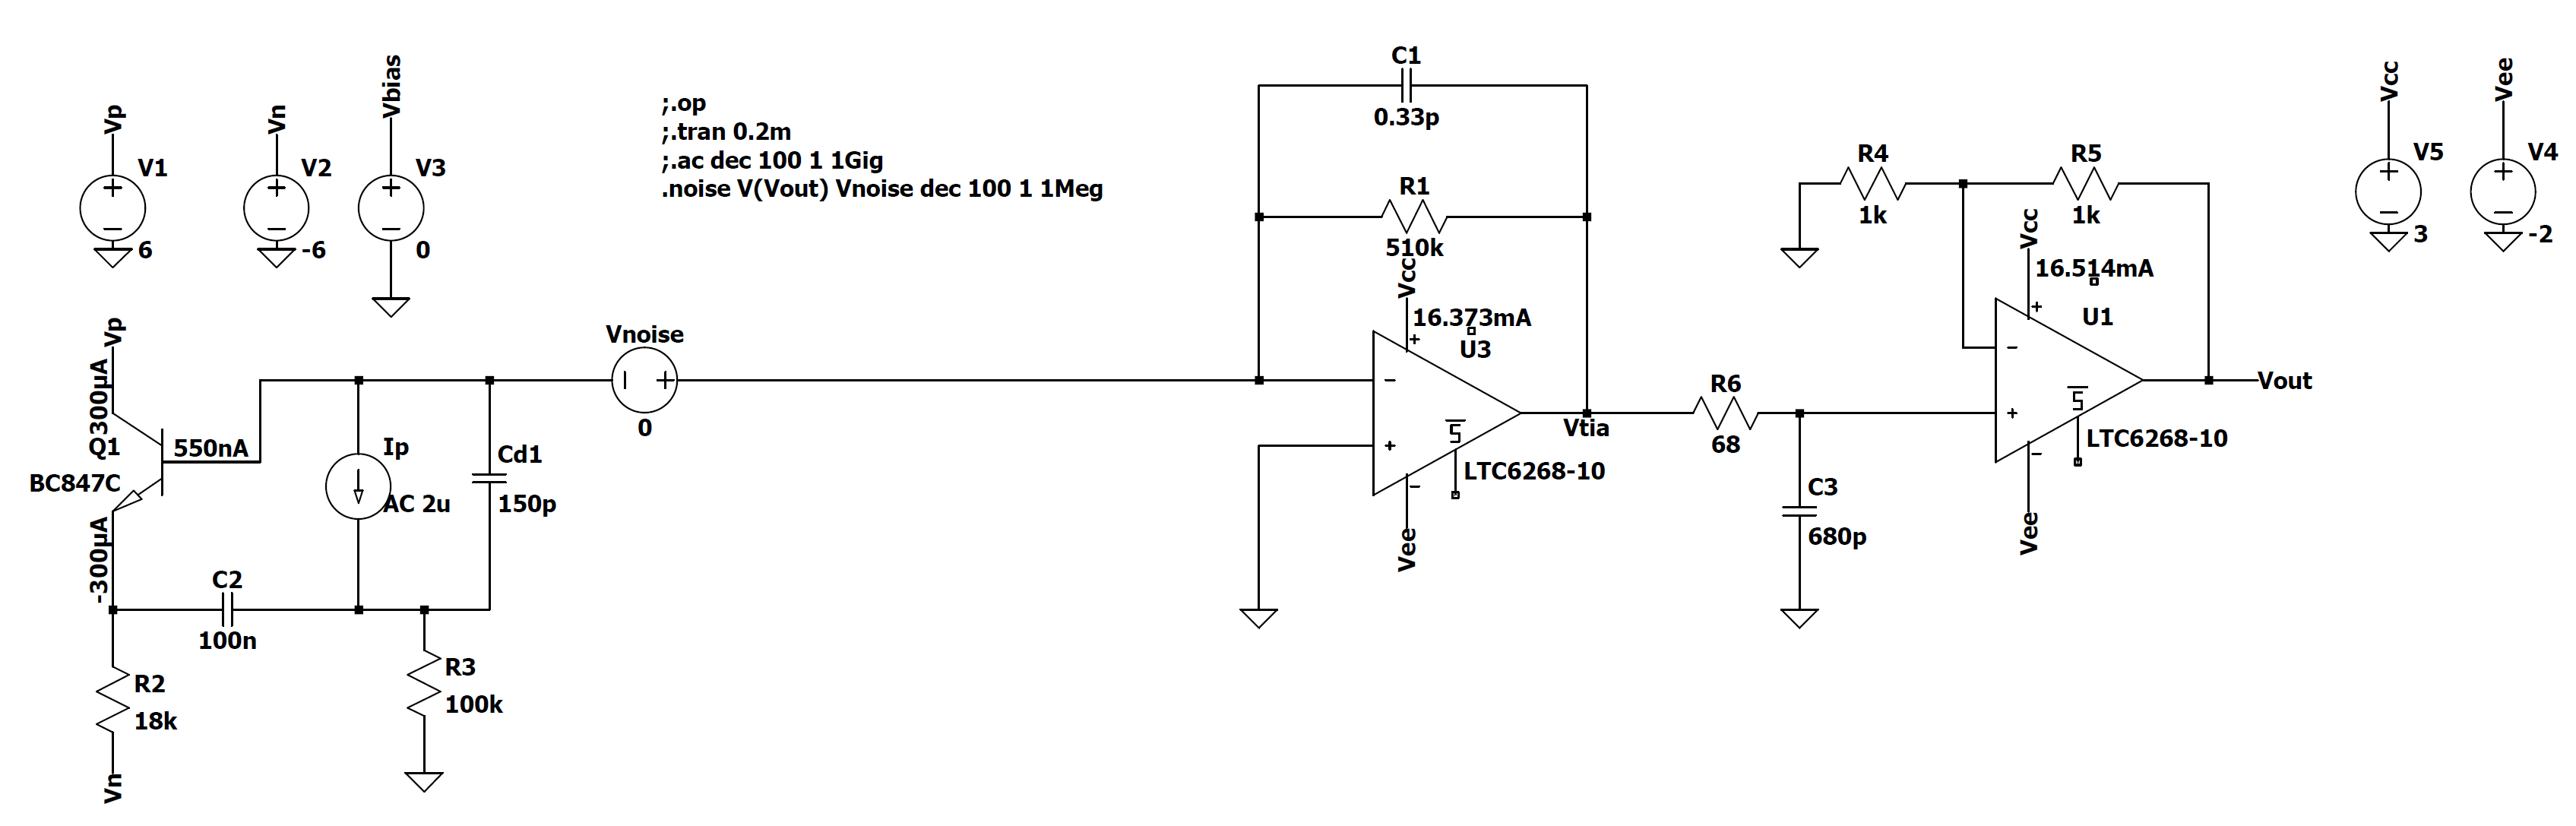

The proposed amplifier consists of a BJT bootstrap stage, a TIA stage, a passive fitler and a non-inverting amplifier. There are two voltage domains because the opamp is only apable of 5.1V peak to peak. Having slightly higher and balanced voltages makes biasing the BJT easier.

One caveat is that the LTC6268-10 is guaranteed to be stable only above gain of 10. This is either not represented in the LTspice model or the application happens to not make the IC oscillate. In practice, this would need to be verified in a physical circuit.

## Transfer Function

I was unable to come up with an analytical model for the transistor frontend. The transistor will have shot noise and the $R_e$ and $R_{bias}$ resistors will have Johnson noise. However, my understanding is that only part of this noise is present at $V_{in}$ because of the feedback loop across $C_D$.

In [97]:
420 * np.sqrt(2*q*300e-6) * 2 * np.pi * 100e-9 * 18e3 * 10e3 / np.sqrt(1 + (2 * np.pi * 10e3 * 100e-9 * 18e3)**2)

def bootstrap_noise(beta, I_C, C_ac, R_e, f):
    omega = 2 * np.pi * f
    shot_noise = np.sqrt(2 * q * I_C)
    tf_R_e_C_ac_mag = omega * R_e * C_ac / np.sqrt(1 + (omega * R_e * C_ac)**2)
    return shot_noise

bootstrap_noise(420, 12 / 18e3, 100e-9, 18e3, 10e3)

1.460593486680443e-11

TIA stage:
\begin{equation}
I_{in} = I_{C_D} + I_{C_f} + I_{R_f}\\
v_- = - \frac{v_{out}}{A_{ol}} \\
I_{C_D} = \frac{v_-}{\frac{1}{sC_D}} = sC_Dv_-\\
I_{C_f} = (v_- - v_{out})s C_f \\
I_{R_f} = (v_- - v_{out})\frac{1}{R_f} \\
I_{in} = v_- s C_D + v_- s C_f - v_{out} s C_f + \frac{v_-}{R_f} - \frac{v_{out}}{R_f} \\
 = v_- \left(sC_D + \frac{1}{R_f} + s C_f\right) - v_{out}\left(\frac{1}{R_f} + s C_f\right)\\
 = - \frac{v_{out}}{A_{ol}} \left( sC_D + \frac{1}{R_f} + s C_f\right) - v_{out}\left( \frac{1}{R_f} + s C_f\right) \\
= -\frac{v_{out}}{A_{ol}}\left( \frac{s C_D R_f + 1 + s C_f R_f}{R_f} \right) - v_{out}\left( \frac{1+s C_f R_f}{R_f} \right) \\
= - \frac{v_{out}}{A_{ol} R_f}\left( 1 + s R_f (C_D + C_f) + A_{ol}(1 + sC_fR_f)\right) \\
-\frac{v_{out}}{I_{in}} = \frac{A_{ol}R_f}{1 + s R_f (C_D + C_f) + A_{ol}(1 + sC_fR_f)}
\end{equation}

\begin{equation}
A_{ol} = \frac{A_0}{1 + \frac{s}{s_p}} = \frac{A_0s_p}{s_p + s} = \frac{\omega_u}{s_p + s}
\end{equation}

for $s >> s_p \approx \frac{\omega_u}{s}$

for $C_D >> C_f, C_D + C_f \approx C_D$

\begin{equation}
-\frac{v_{out}}{I_{in}} = \frac{\omega_u R_f}{1 + s^2R_fC_D + \omega_u + s \omega_u C_f R_f}\\
= R_f \frac{\frac{\omega_u}{R_f C_D}}{s^2 + s \frac{\omega_uC_f}{C_D} + \frac{1+\omega_u}{R_fC_D}}
\end{equation}

The GBP product of the opamp is large: $\omega_u + 1 \approx \omega_u$

$\zeta = \frac{1}{\sqrt{2}}$

$\omega_u = 2 \pi f_T$

\begin{equation}
\omega^2_0= \frac{\omega_u}{R_fC_D}\\
\omega_0 = \sqrt{\frac{\omega_u}{R_fC_D}}
\end{equation}


\begin{equation}
H_1(s) = R_f \frac{\frac{\omega_u}{R_fC_D}}{s^2 + s 2 \zeta \sqrt{\frac{\omega_u}{R_fC_D}} + \frac{\omega_u}{R_fC_D}}\\
|H_1(s)| = R_f \frac{\omega^2_0}{\sqrt{(s\sqrt{2}\omega_0)^2 + (\omega^2_0-s^2)^2}}
\end{equation}

Passive filter:

\begin{equation}
H_2(s) = \frac{1}{1 + sR_{filter}C_{filter}}\\
|H_2(s)| = \frac{1}{\sqrt{(sR_{filter}C_{filter})^2 + 1}}
\end{equation}

Non-inverting amplifier:

\begin{equation}
|H_3(s)| = 1 + \frac{R_2}{R_1}
\end{equation}

The non-inverting amplifier is modelled assuming an ideal opamp. This is a reasonable simplification because the 2nd half of the LTC6268-10 opamp is used which has a very high GBP.

Full structure:

\begin{equation}
|H(s)| = |H_1(s)| \times |H_2(s)| \times |H_3(s)|
\end{equation}

## Predicted Gain and Noise

Using the transfer function derived in the previous section, the structure is populated with 2 different opamps: LTC6269 and ADA4891. For each the predicted gain and noise are plotted.

Note that the noise from the frontend is missing in the model which is why the calculated value is around 70pA under the simulated value.

In [98]:
C_D = 150e-12 # pF
C_D_eq = 2.5e-12 # pf

# LTC6268-10
e_namp_ltc = 4e-9 # nV
i_namp_ltc = 7e-15 # fA
f_T_ltc = 4e9 # GHz

# AD8675
e_namp_ad = 2.8e-9 # nV
i_namp_ad = 300e-15 # fA
f_T_ad = 10e6 # MHz


'dB at 1MHz: 108.69508131188641'

'TIA noise peak at: 280003.7997479975 mag: 7.065013833445191e-08'

'Structure noise peak at: 1.0 mag: 1.416227182340426e-07'

'integrated input noise: 5.239176193749923e-10 Amp NF: 0.7749941549993138 dB ratio 1.195361916881478'

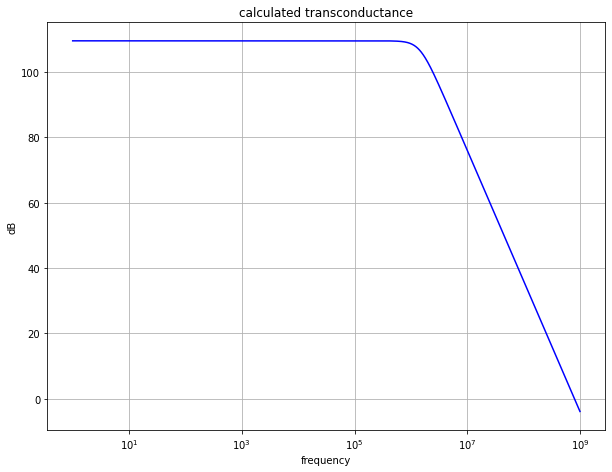

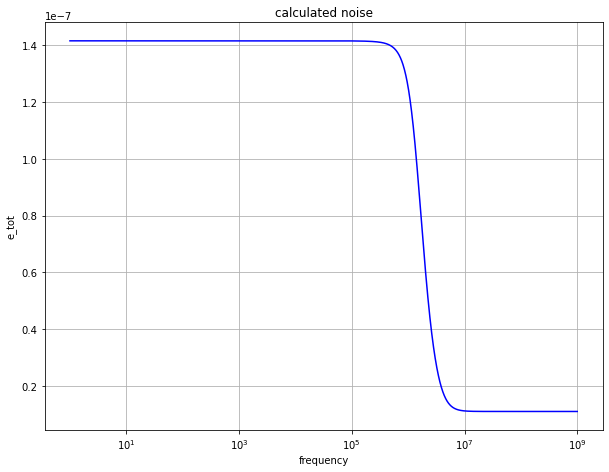

In [99]:
#analyze(C_D_eq, 0.33e-12, 510e3, e_namp_ltc, i_namp_ltc, f_T_ltc, 0.68e-9, 68, 1e3, 1e3)
analyze(C_D_eq, 4e-12, 301e3, e_namp_ad, i_namp_ad, f_T_ad, 0.68e-9, 68, 1e3, 1e3)


### Noise Contributions

The noise density will vary depending on frequency. Not sure how to represent this in a table?

In [146]:
def component_noise(C_D, C_f, R_e, R_bias, R_f, R_1, R_2, R_filter, C_filter, e_namp, i_namp, f_T):
    points = 10**5
    limit = 10**9
    
    f = np.linspace(1, limit, points)
    s = np.multiply(2*np.pi, f)

    zeta = 1 / np.sqrt(2)
    omega_u = 2 * np.pi * f_T
    omega_0_2 = omega_u / (R_f*C_D)
    omega_0 = np.sqrt(omega_0_2)

    tf_tia_mag = R_f * omega_0_2 / np.sqrt( (s*np.sqrt(2)*omega_0)**2 + (omega_0_2-s**2)**2)
    tf_filter_mag = 1 / np.sqrt((s*R_filter*C_filter)**2 + 1)
    tf_noninv_mag = 1 + R_2 / R_1 # assuming ideal opamp
    tf_full_mag = tf_tia_mag * tf_filter_mag * tf_noninv_mag
    
    e_nQ1 = np.sqrt(2 * q * 300e-6) * tf_full_mag
    e_nQ1_tot = np.trapz(e_nQ1, np.sqrt(f))
    
    i_tia_e_na = e_namp * s * C_D
    e_tia_na = i_tia_e_na * tf_full_mag
    e_tia_na_tot = np.trapz(e_tia_na, np.sqrt(f)) 

    i_nRe2 = 4 * kT / R_e
    e_nRe = np.sqrt(i_nRe2) * tf_full_mag
    e_nRe_tot = np.trapz(e_nRe, np.sqrt(f))

    i_nRbias2 = 4 * kT / R_bias
    e_nRbias = np.sqrt(i_nRbias2) * tf_full_mag
    e_nRbias_tot = np.trapz(e_nRbias, np.sqrt(f))

    e_nRf2 = 4 * kT * R_f
    e_nRf = (np.sqrt(e_nRf2) / R_f) * tf_full_mag
    e_nRf_tot = np.trapz(e_nRf, np.sqrt(f))

    e_nRfilter = np.sqrt(4 * kT * R_filter) * tf_noninv_mag
    e_nRfilter_tot = e_nRfilter * np.sqrt(1e6)
    
    e_nR2 = np.sqrt(4 * kT * R_2)
    e_nR2_tot = e_nR2 * np.sqrt(1e6)

    e_nR1 = np.sqrt(4 * kT * R_1) * tf_noninv_mag
    e_nR1_tot = e_nR1 * np.sqrt(1e6)

    R_1_p_R_2 = R_1 * R_2 / (R_1 + R_2)
    e_i_namp = i_namp * R_1_p_R_2 * tf_noninv_mag
    e_e_namp = e_namp * tf_noninv_mag
    e_e_namp_tot = e_e_namp * np.sqrt(1e6)
    
    noise = { 'Q1 (wrong)': [e_nQ1_tot, e_nQ1_tot / 1e6],
        'Re (wrong)': [e_nRe_tot, e_nRe_tot / 1e6],
        'Rbias (wrong)': [e_nRbias_tot, e_nRbias_tot / 1e6],
        'Rf': [e_nRf_tot, e_nRf_tot / 1e6],
        'Rfilter': [e_nRfilter, e_nRfilter / 1e6],
        'R5': [e_nR2_tot, e_nR2_tot / 1e6],
        'R4': [e_nR1_tot, e_nR1_tot / 1e6],
        'IC1': [e_tia_na_tot, e_tia_na_tot / 1e6],
        'IC2': [e_e_namp_tot, e_e_namp_tot / 1e6]}
    print ("{:<15} {:<25} {:<25}".format('Component','output ref rms','input ref rms'))
    for k, v in noise.items():
        o, i = v
        print ("{:<15} {:<25} {:<25}".format(k, o, i))
        
component_noise(C_D_eq, 0.33e-12, 18e3, 100e3, 510e3, 1e3, 1e3, 68, 0.68e-9, e_namp_ad, i_namp_ad, f_T_ad)

Component       output ref rms            input ref rms            
Q1 (wrong)      0.012568885276873127      1.2568885276873127e-08   
Re (wrong)      0.0012304247527740086     1.2304247527740085e-09   
Rbias (wrong)   0.0005220250118557697     5.220250118557697e-10    
Rf              0.00023115656056185715    2.3115656056185714e-10   
Rfilter         2.122338333065678e-09     2.122338333065678e-15    
R5              4.069397989875161e-06     4.069397989875161e-12    
R4              8.138795979750322e-06     8.138795979750321e-12    
IC1             4.1924265792613823e-05    4.192426579261382e-11    
IC2             5.6e-06                   5.5999999999999996e-12   


Although I am pretty sure my calculations for Q1, Re and Rbias are wrong, I think Q1 is the largest contributor to input referred noise.

### Bill of Materials

A table listing components used, quantity, active power (if applicable) and cost for each item assuming a purchase quantity of 1000, in addition to the total cost and power. Include a link to a Digikey (or equivalent) listing for each component.

In [156]:
    bom = { 'Q1': ['BC847C', '2mW', '$0.043'],
        'Re': ['18k', '1.6mW', '$0.121'],
        'Rbias': ['100k', '3.4fW', '$0.059'],
        'Rf': ['510k', '156nW', '$0.01'],
        'Rfilter': ['68', '0W', '$0.029'],
        'R5': ['1k', '80uW', '$0.038'],
        'R4': ['1k', '80uW', '$0.038'],
        'IC1-1': ['LTC6269-10', '81mW', '$5.65'],
        'IC1-2': ['LTC6269-10', '81mW', '-'],
        'C1': ['0.33p', 0, '$0.008'],
        'C2': ['100n', 0, '$0.007'],
        'C3': ['680p', 0, '$0.298']}
    print ("{:<15} {:<25} {:<25} {:<25}".format('Component','type','power', 'cost/1000'))
    for k, v in bom.items():
        s, p, c = v
        print ("{:<15} {:<25} {:<25} {:<25}".format(k, s, p, c))

Component       type                      power                     cost/1000                
Q1              BC847C                    2mW                       $0.043                   
Re              18k                       1.6mW                     $0.121                   
Rbias           100k                      3.4fW                     $0.059                   
Rf              510k                      156nW                     $0.01                    
Rfilter         68                        0W                        $0.029                   
R5              1k                        80uW                      $0.038                   
R4              1k                        80uW                      $0.038                   
IC1-1           LTC6269-10                81mW                      $5.65                    
IC1-2           LTC6269-10                81mW                      -                        
C1              0.33p                     0                 

Cost obtained from mouser.com except for LTC6268-10. The LTC6268-10 was used for simulation however the LTC6269-10 was used for purchasing. The latter is a 2 channel version of the first. The price on mouser is only available on request so the MSRP from analog.com was used.

## Verification

### Simulated Noise

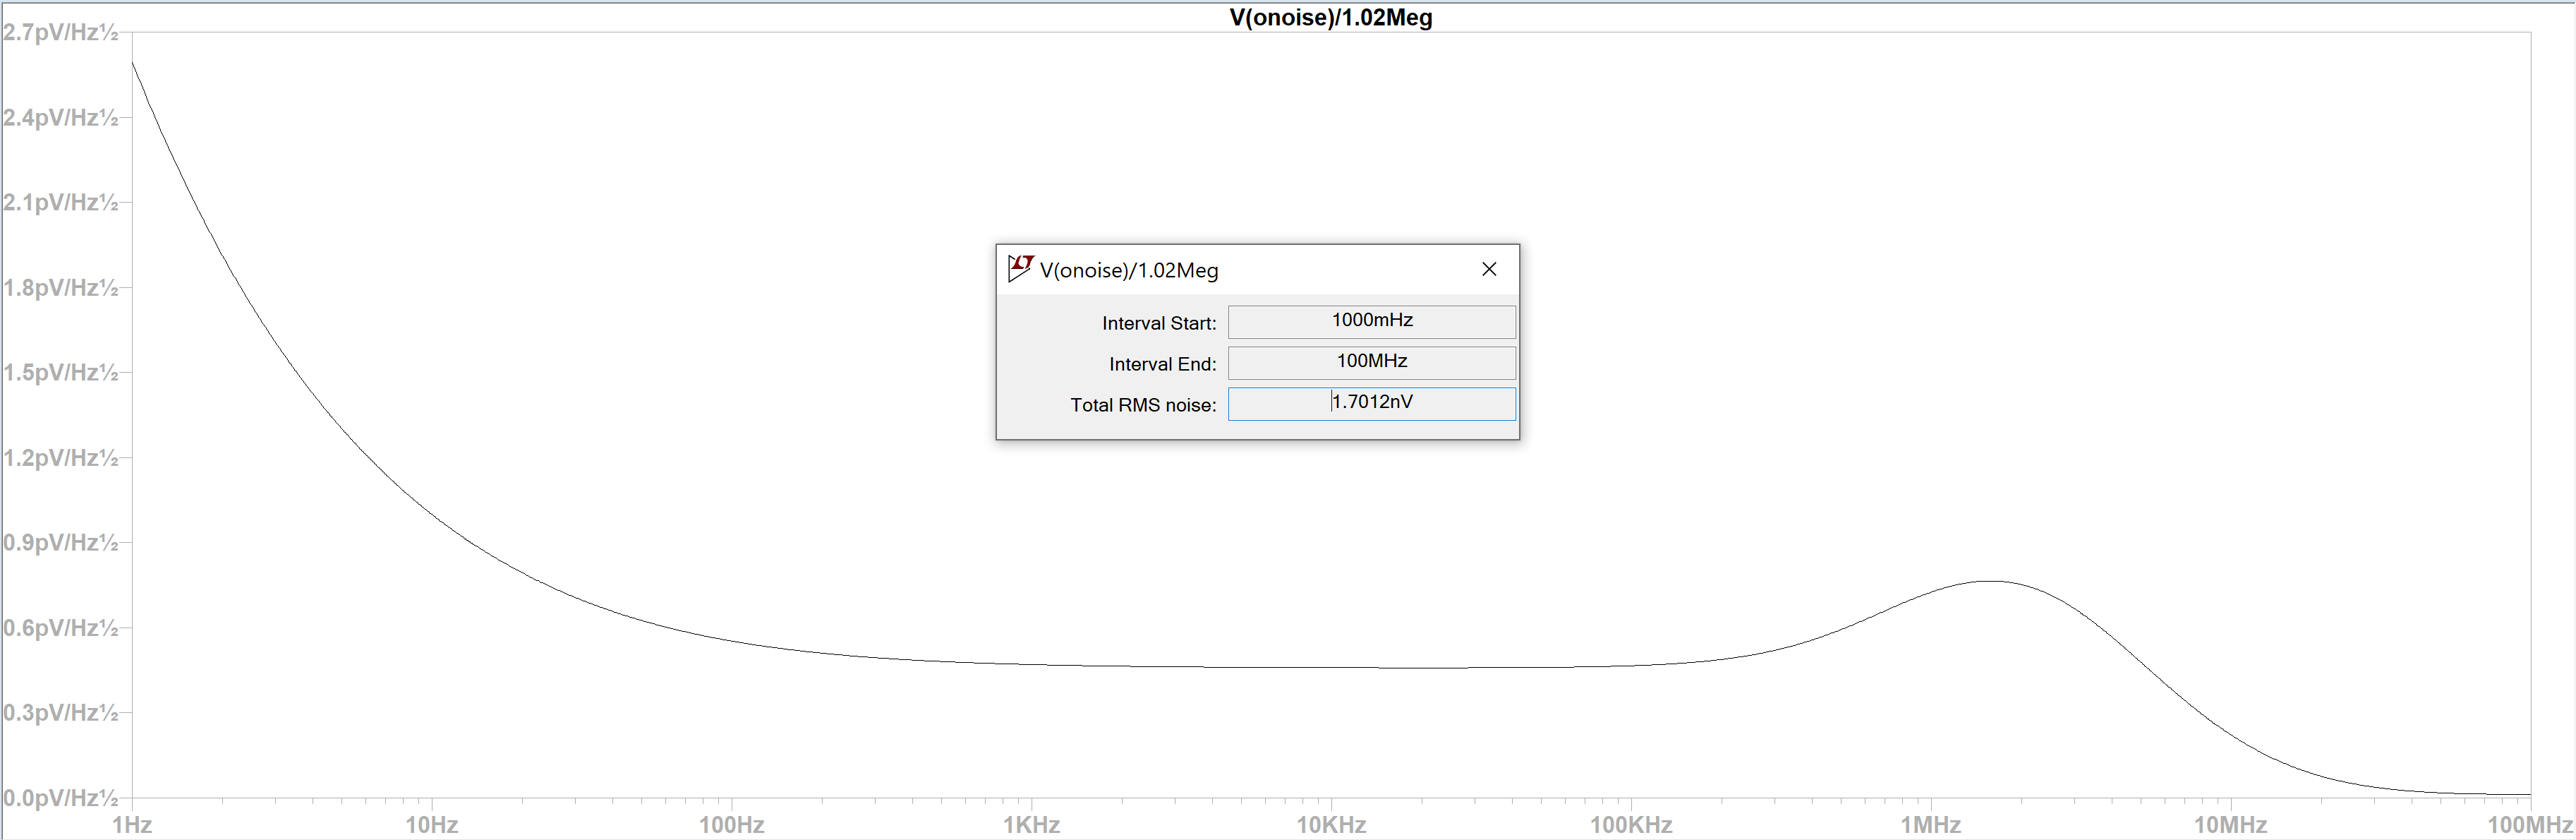

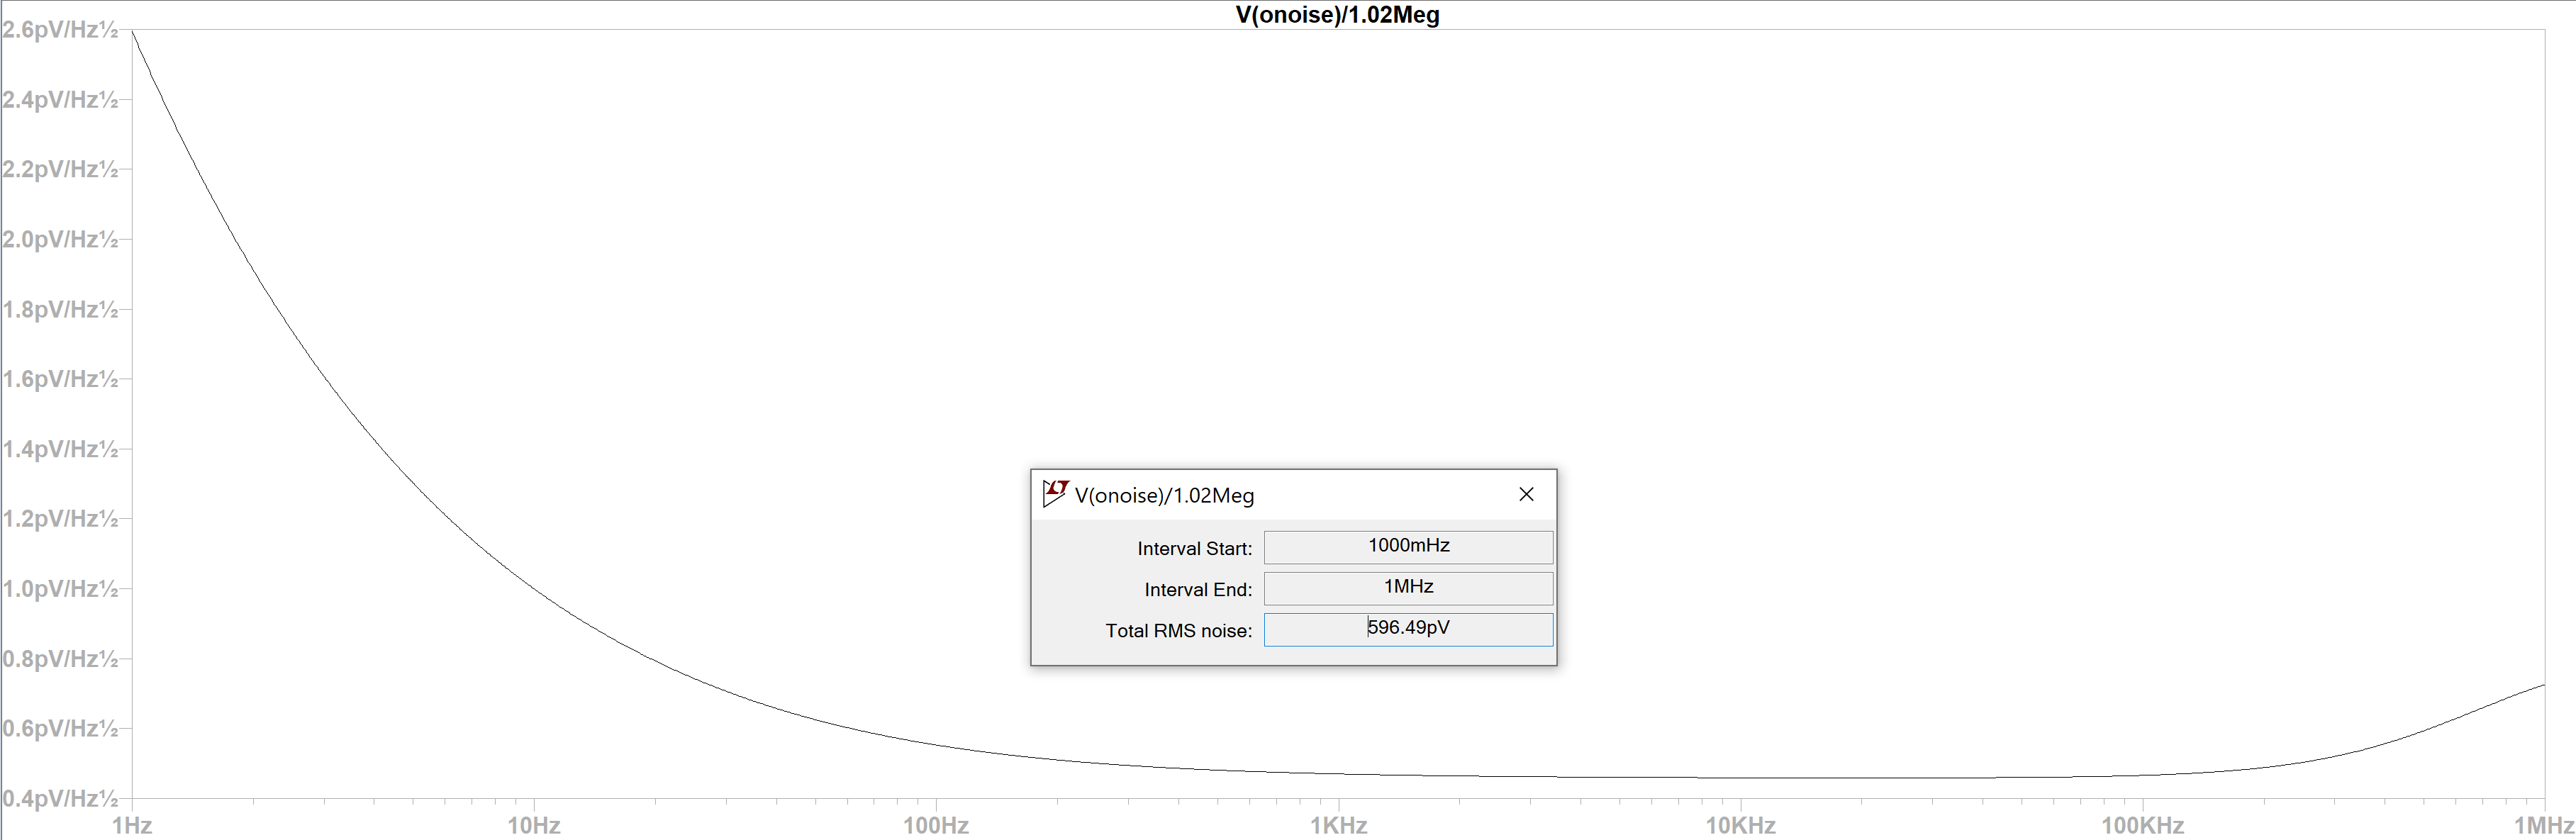

### Simulated Frequency Response

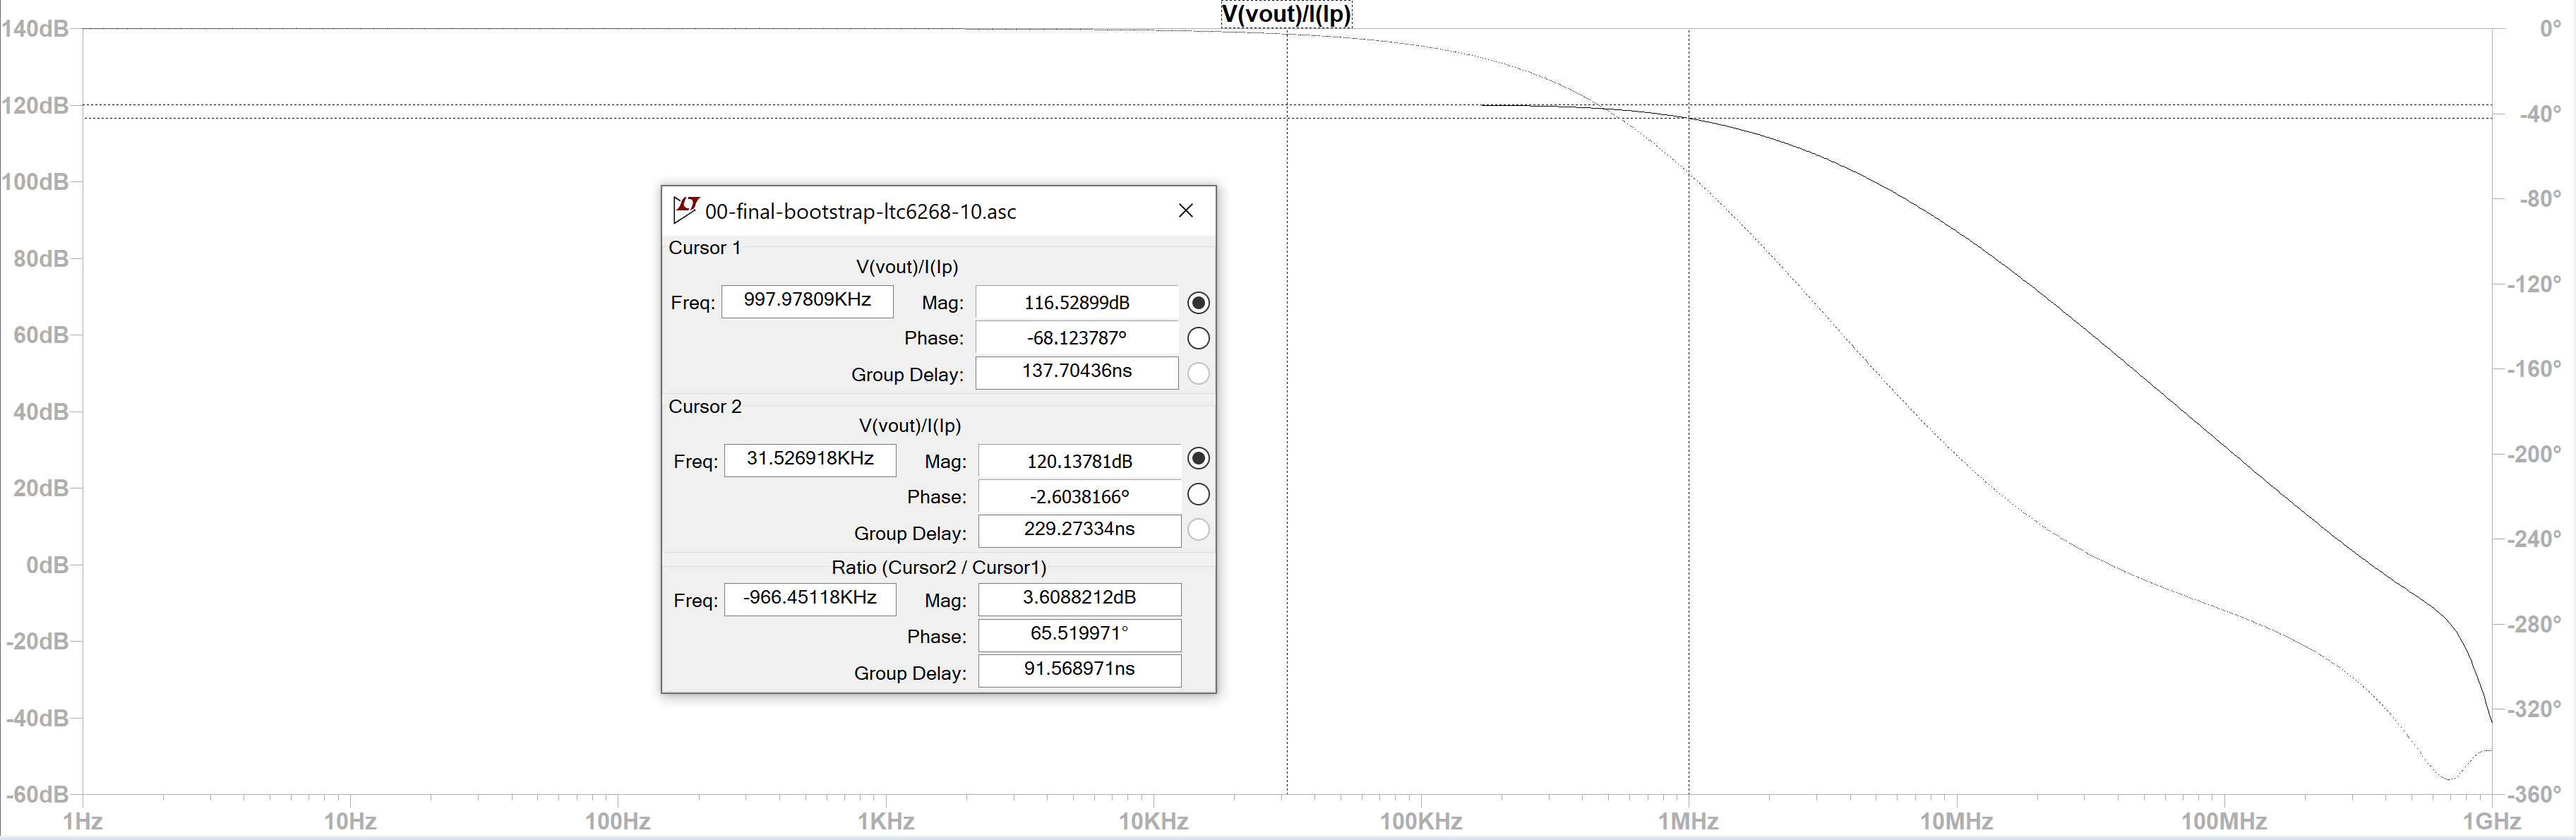

### Input Impedance

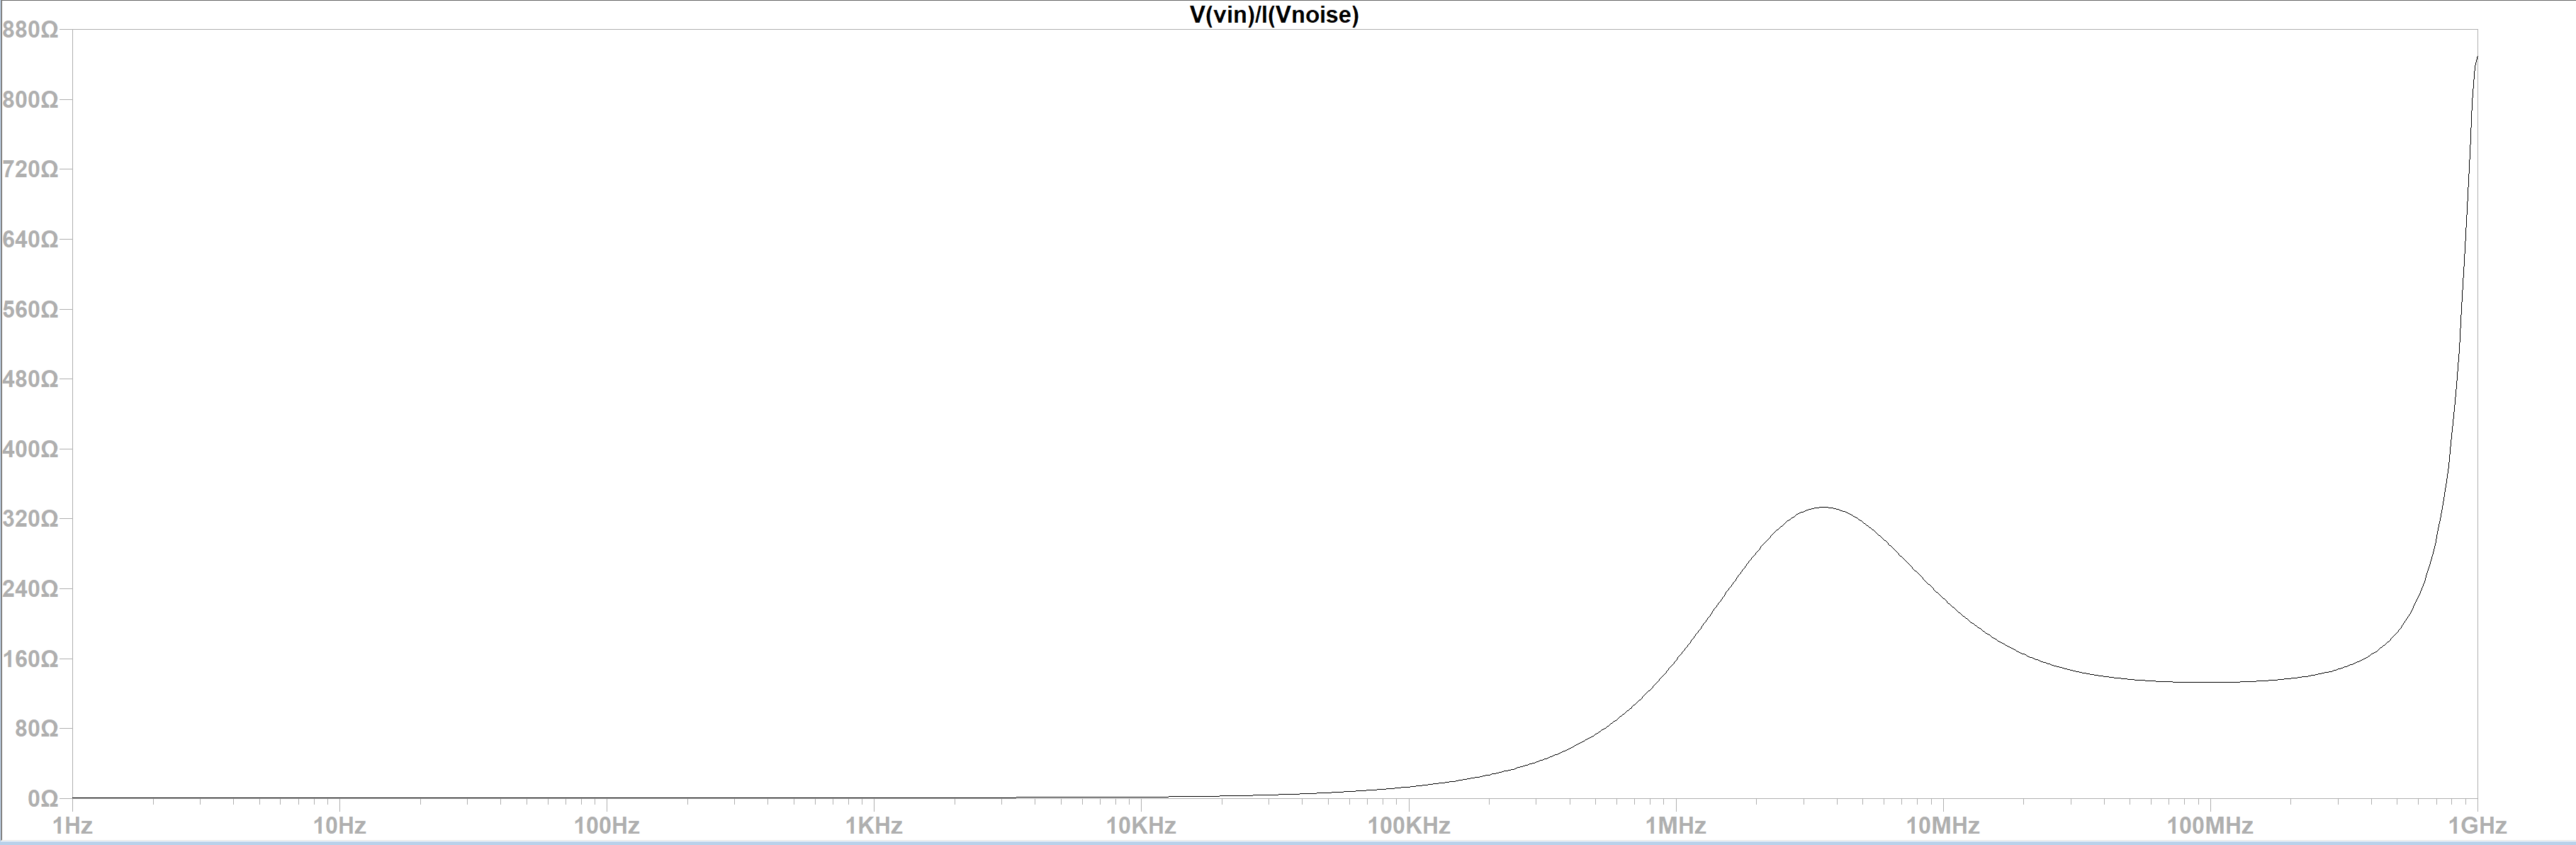

### Output Step Response

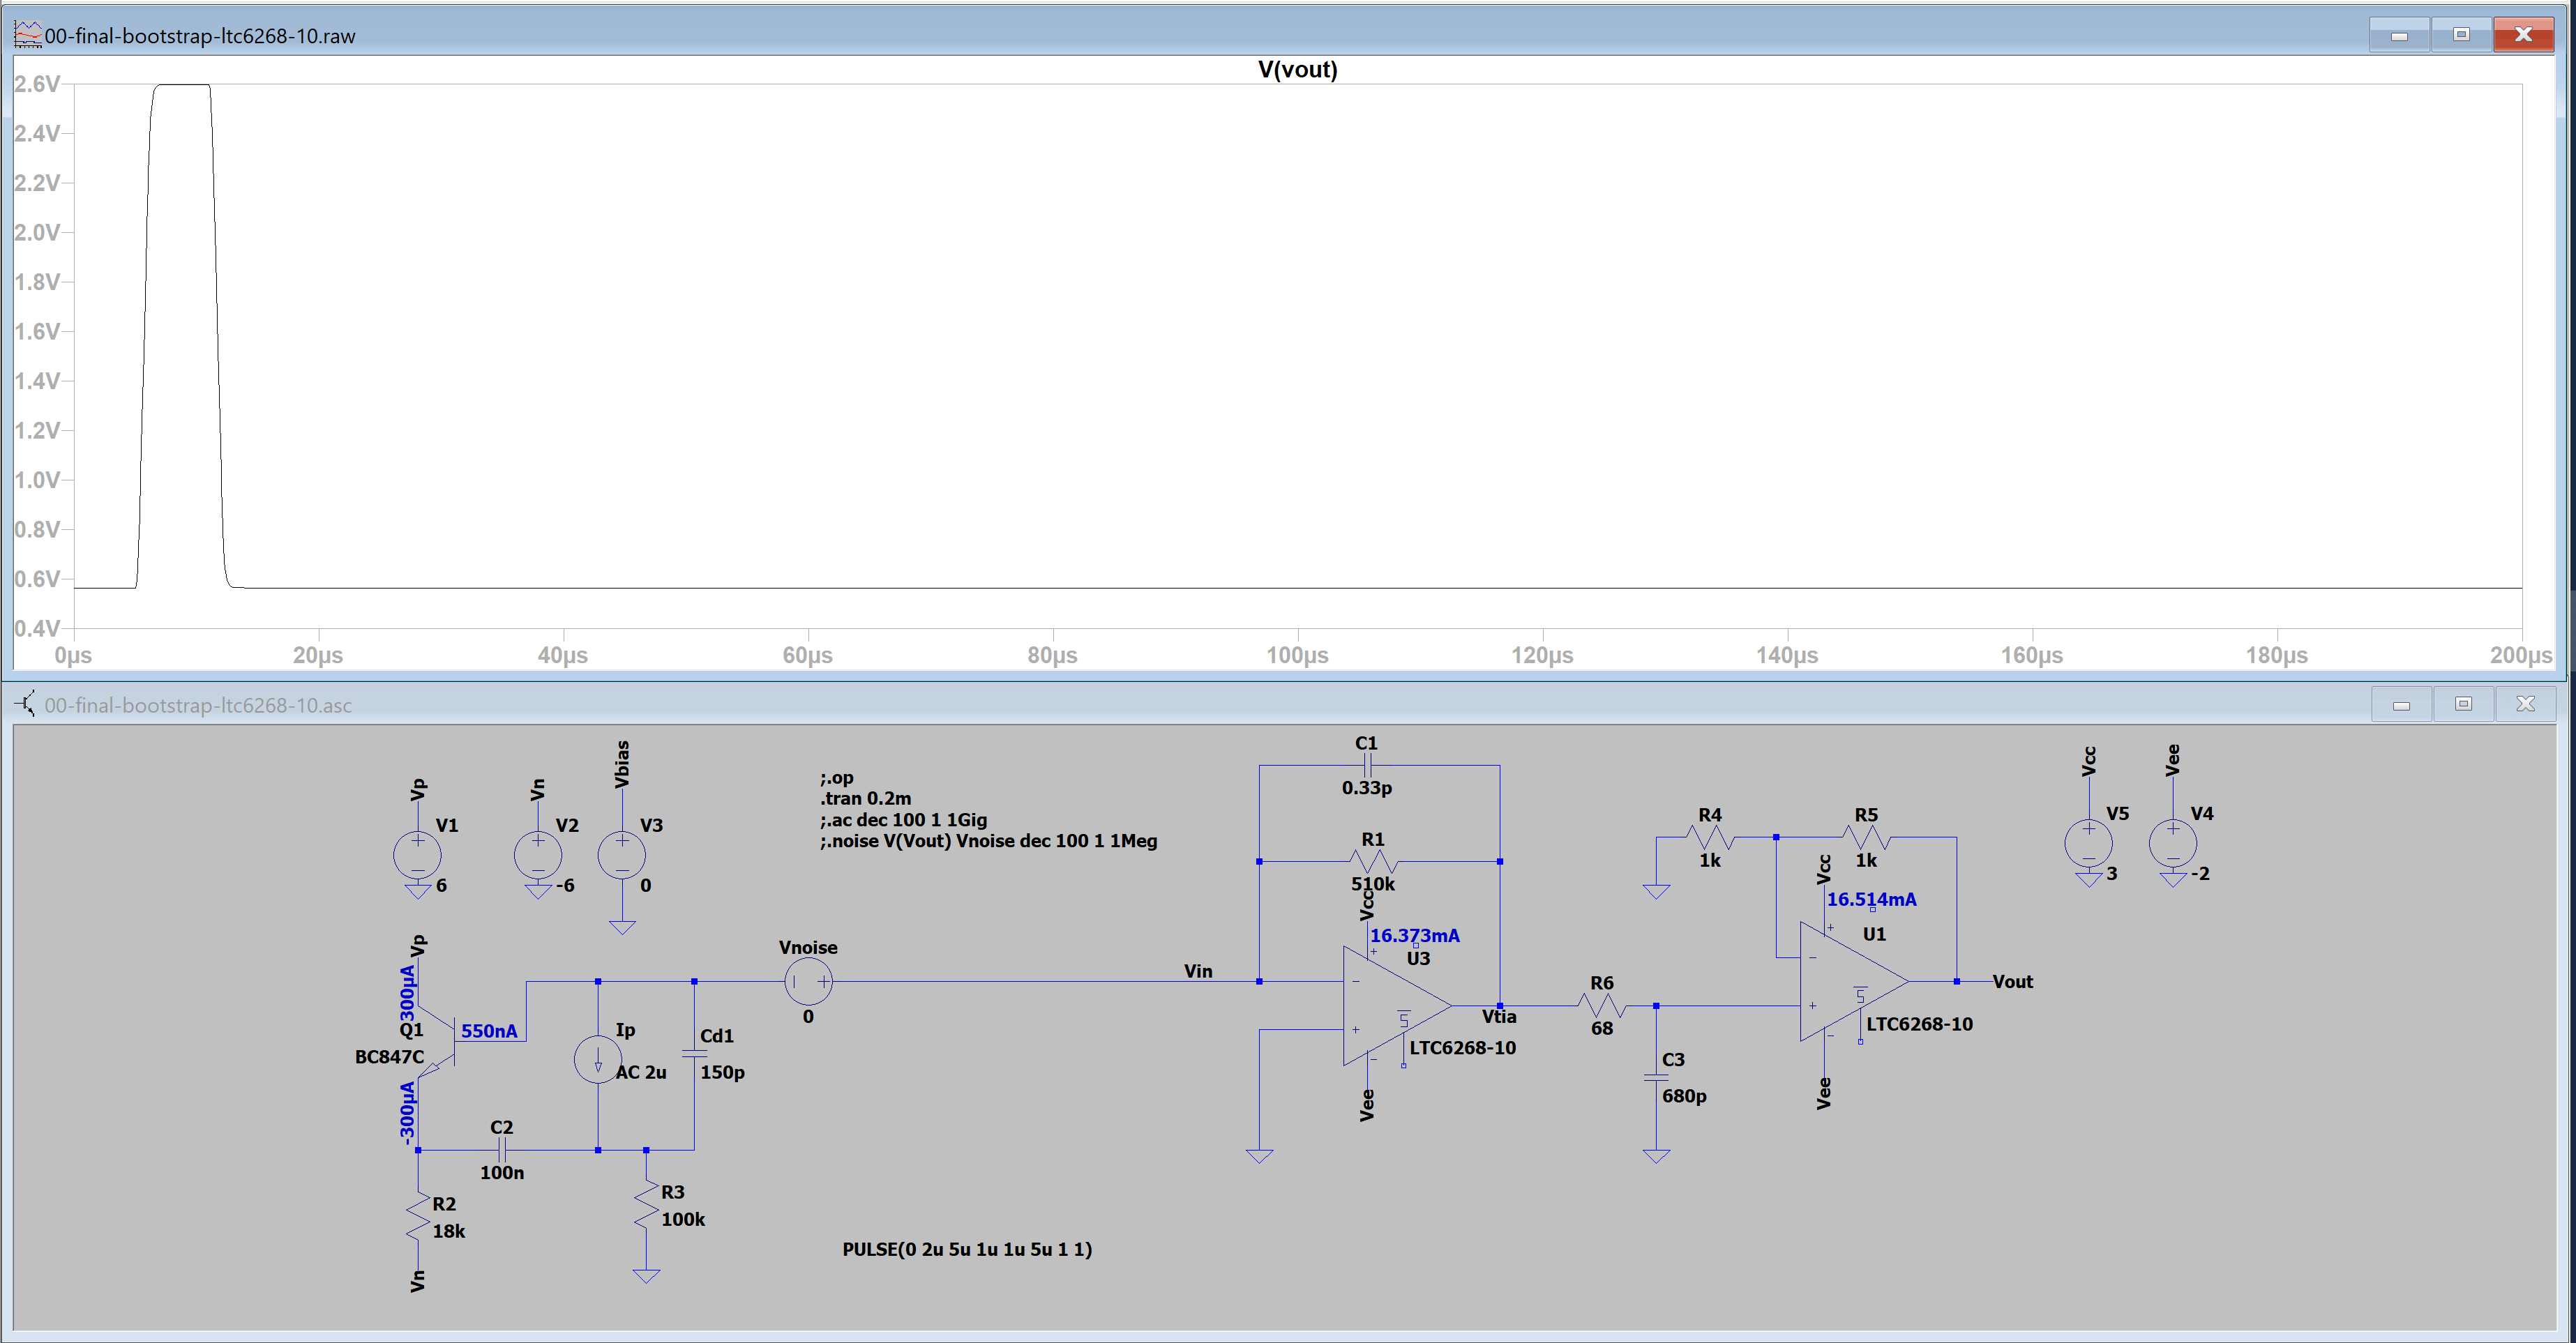

## Discussion

From the results reported in Hobbs' paper it seems that with the right choice of components the design specification can be met while keeping the structure relatively simple. However, while trying to reproduce Hobbs' results, some inconsistencies were discovered which led to the design proposed in this report which however does not fully meet the design specifications. Two major questions are investigated:

1. What role does the choice of transistor play in the frontend architecture?
2. What improvement can be achieved by including a cascode structure?

To answer question 1, a reference structure was built which realizes current from the photo-diode as voltage across a $1M\Ohm$ resistor. The photo-diode model in the reference structure is set to have a diode capacitance of $2.5pF$. The quality of each structure under consideration is evaluated as the sum of squared differences between the two response curves:

\begin{equation}
S = \frac{1}{bw}\int{\left(x(f)-y(f)\right)^2} df
\end{equation}

To ensure that no information is lost in the shapes of the curves when examining the test statistic, plots are included which plot each response in contrast to the reference.

Two structures are evaluated with a permutation of 2 transistors. One of the transistors is the MPSA18 used in Hobbs bootstrap stage and the other is the BC847C used in Diman's bootstrap stage. This gives a total of 4 evaluated structures:

1. Diman structure with BC847C transistor
2. Diman structure with MPSA18 transistor
3. Hobbs structure with BC847C transistor
4. Hobbs structure with MPSA18 transistor


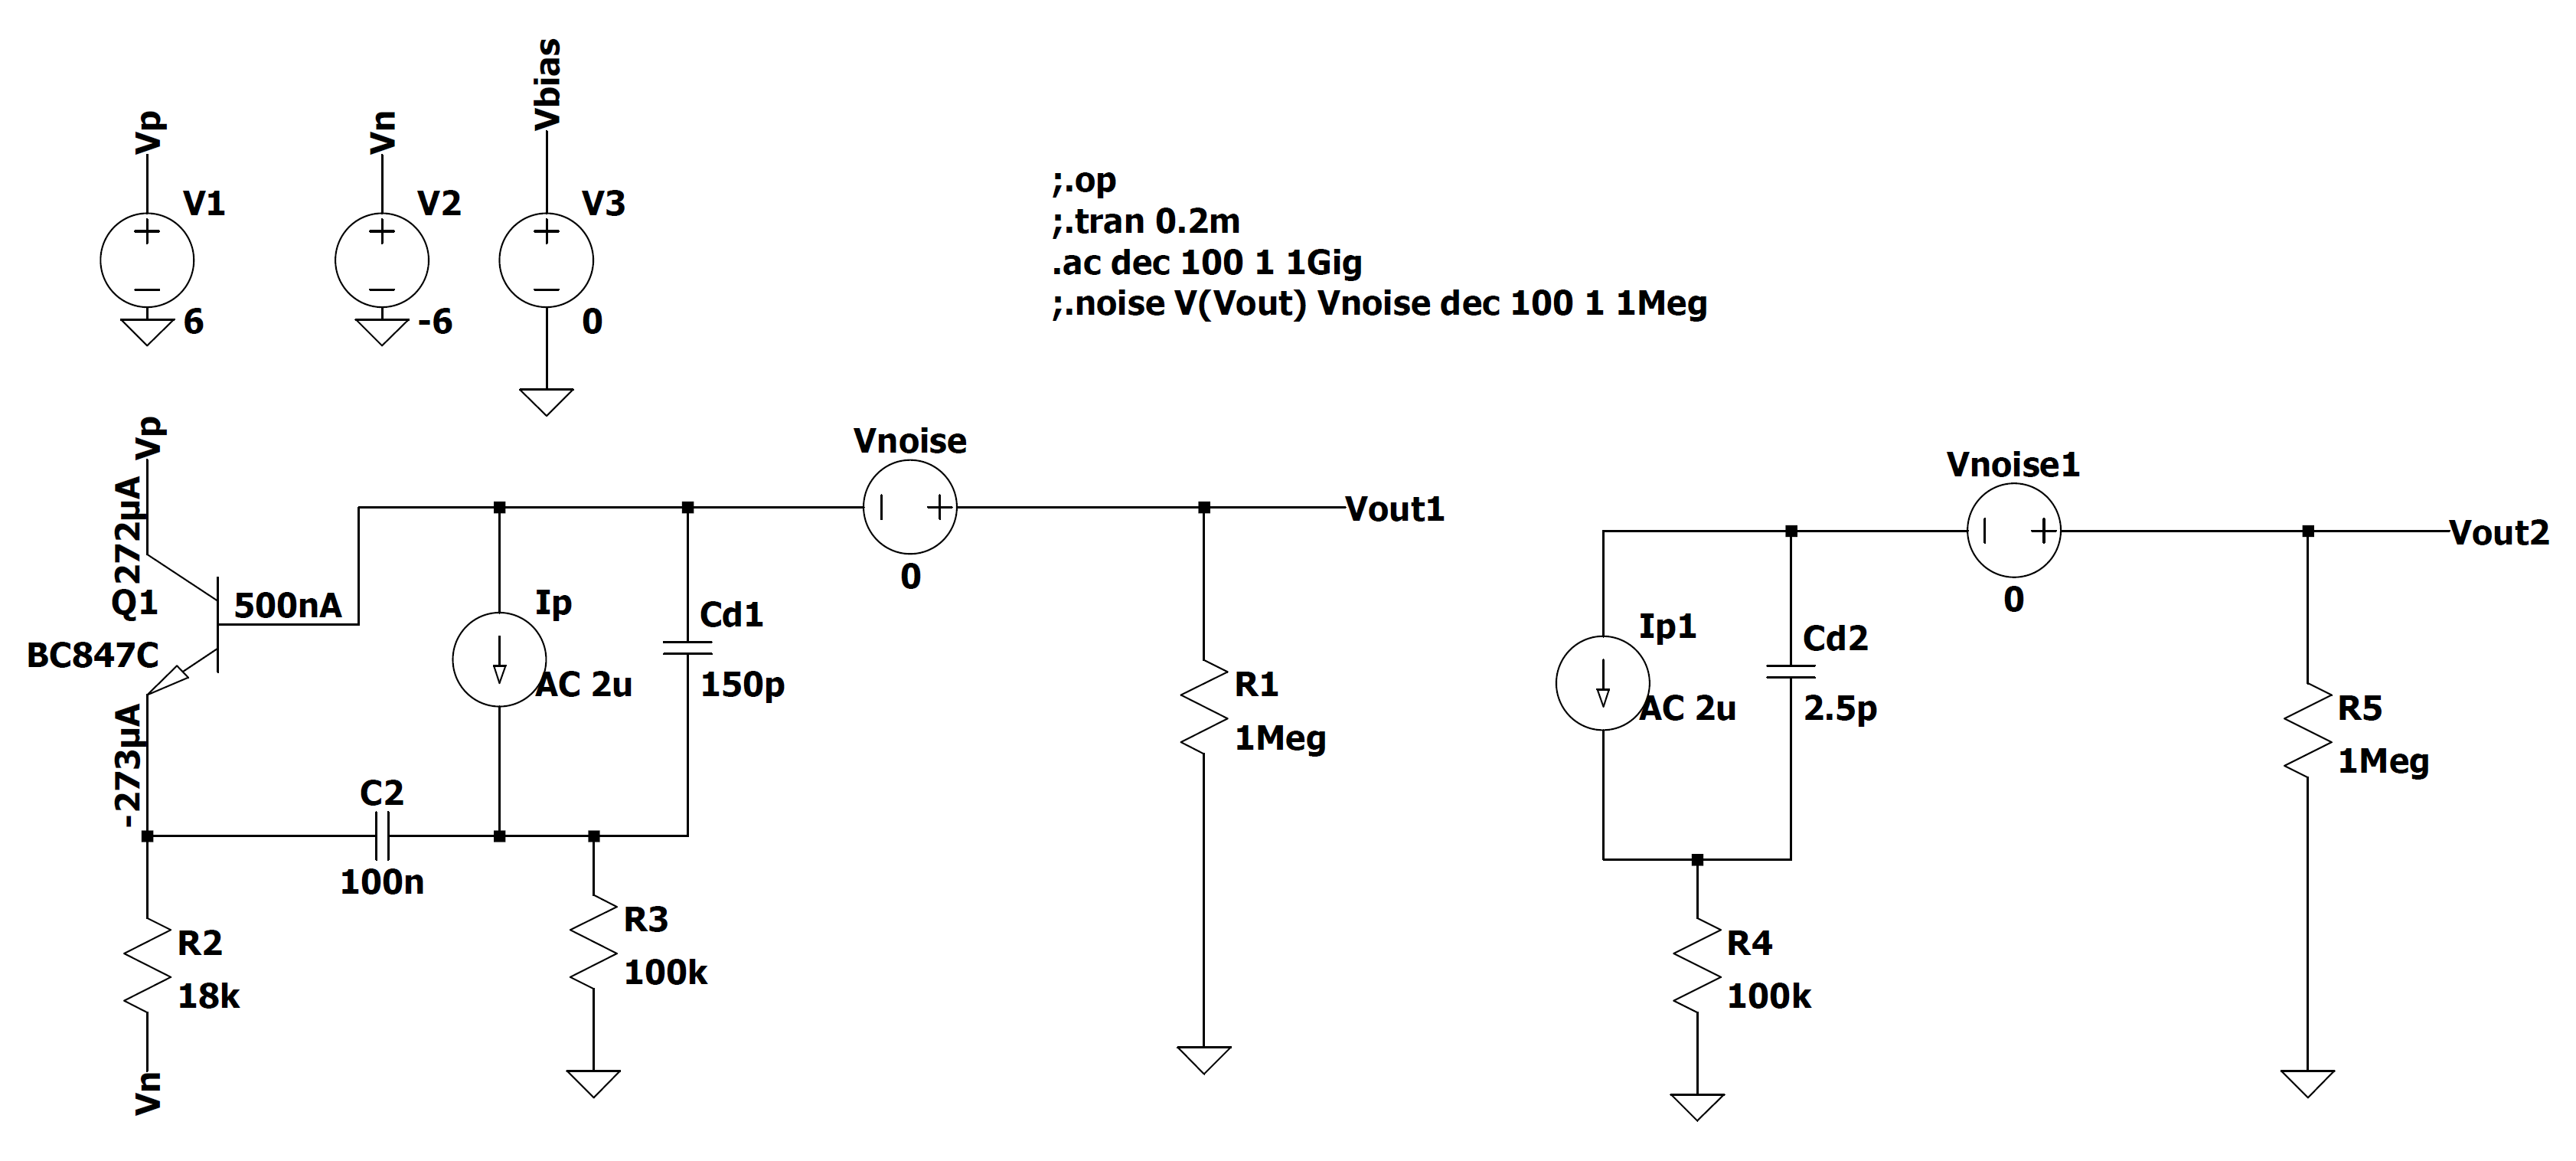

'(x - y)^2/n: 0.028081057228820528'

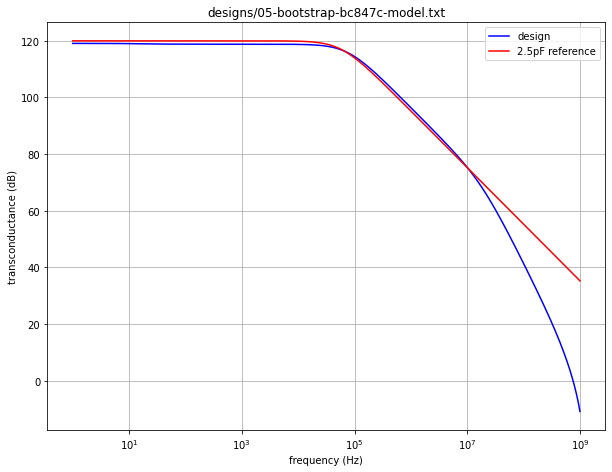

In [51]:
evaluate_frontend("designs/05-bootstrap-bc847c-model.txt")

'(x - y)^2/n: 0.12261210746517662'

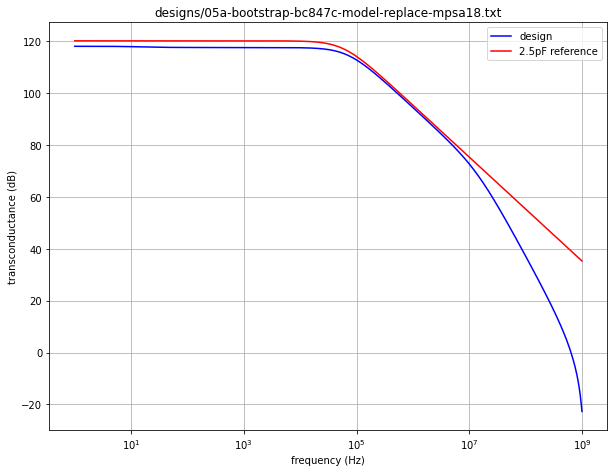

In [53]:
evaluate_frontend("designs/05a-bootstrap-bc847c-model-replace-mpsa18.txt")

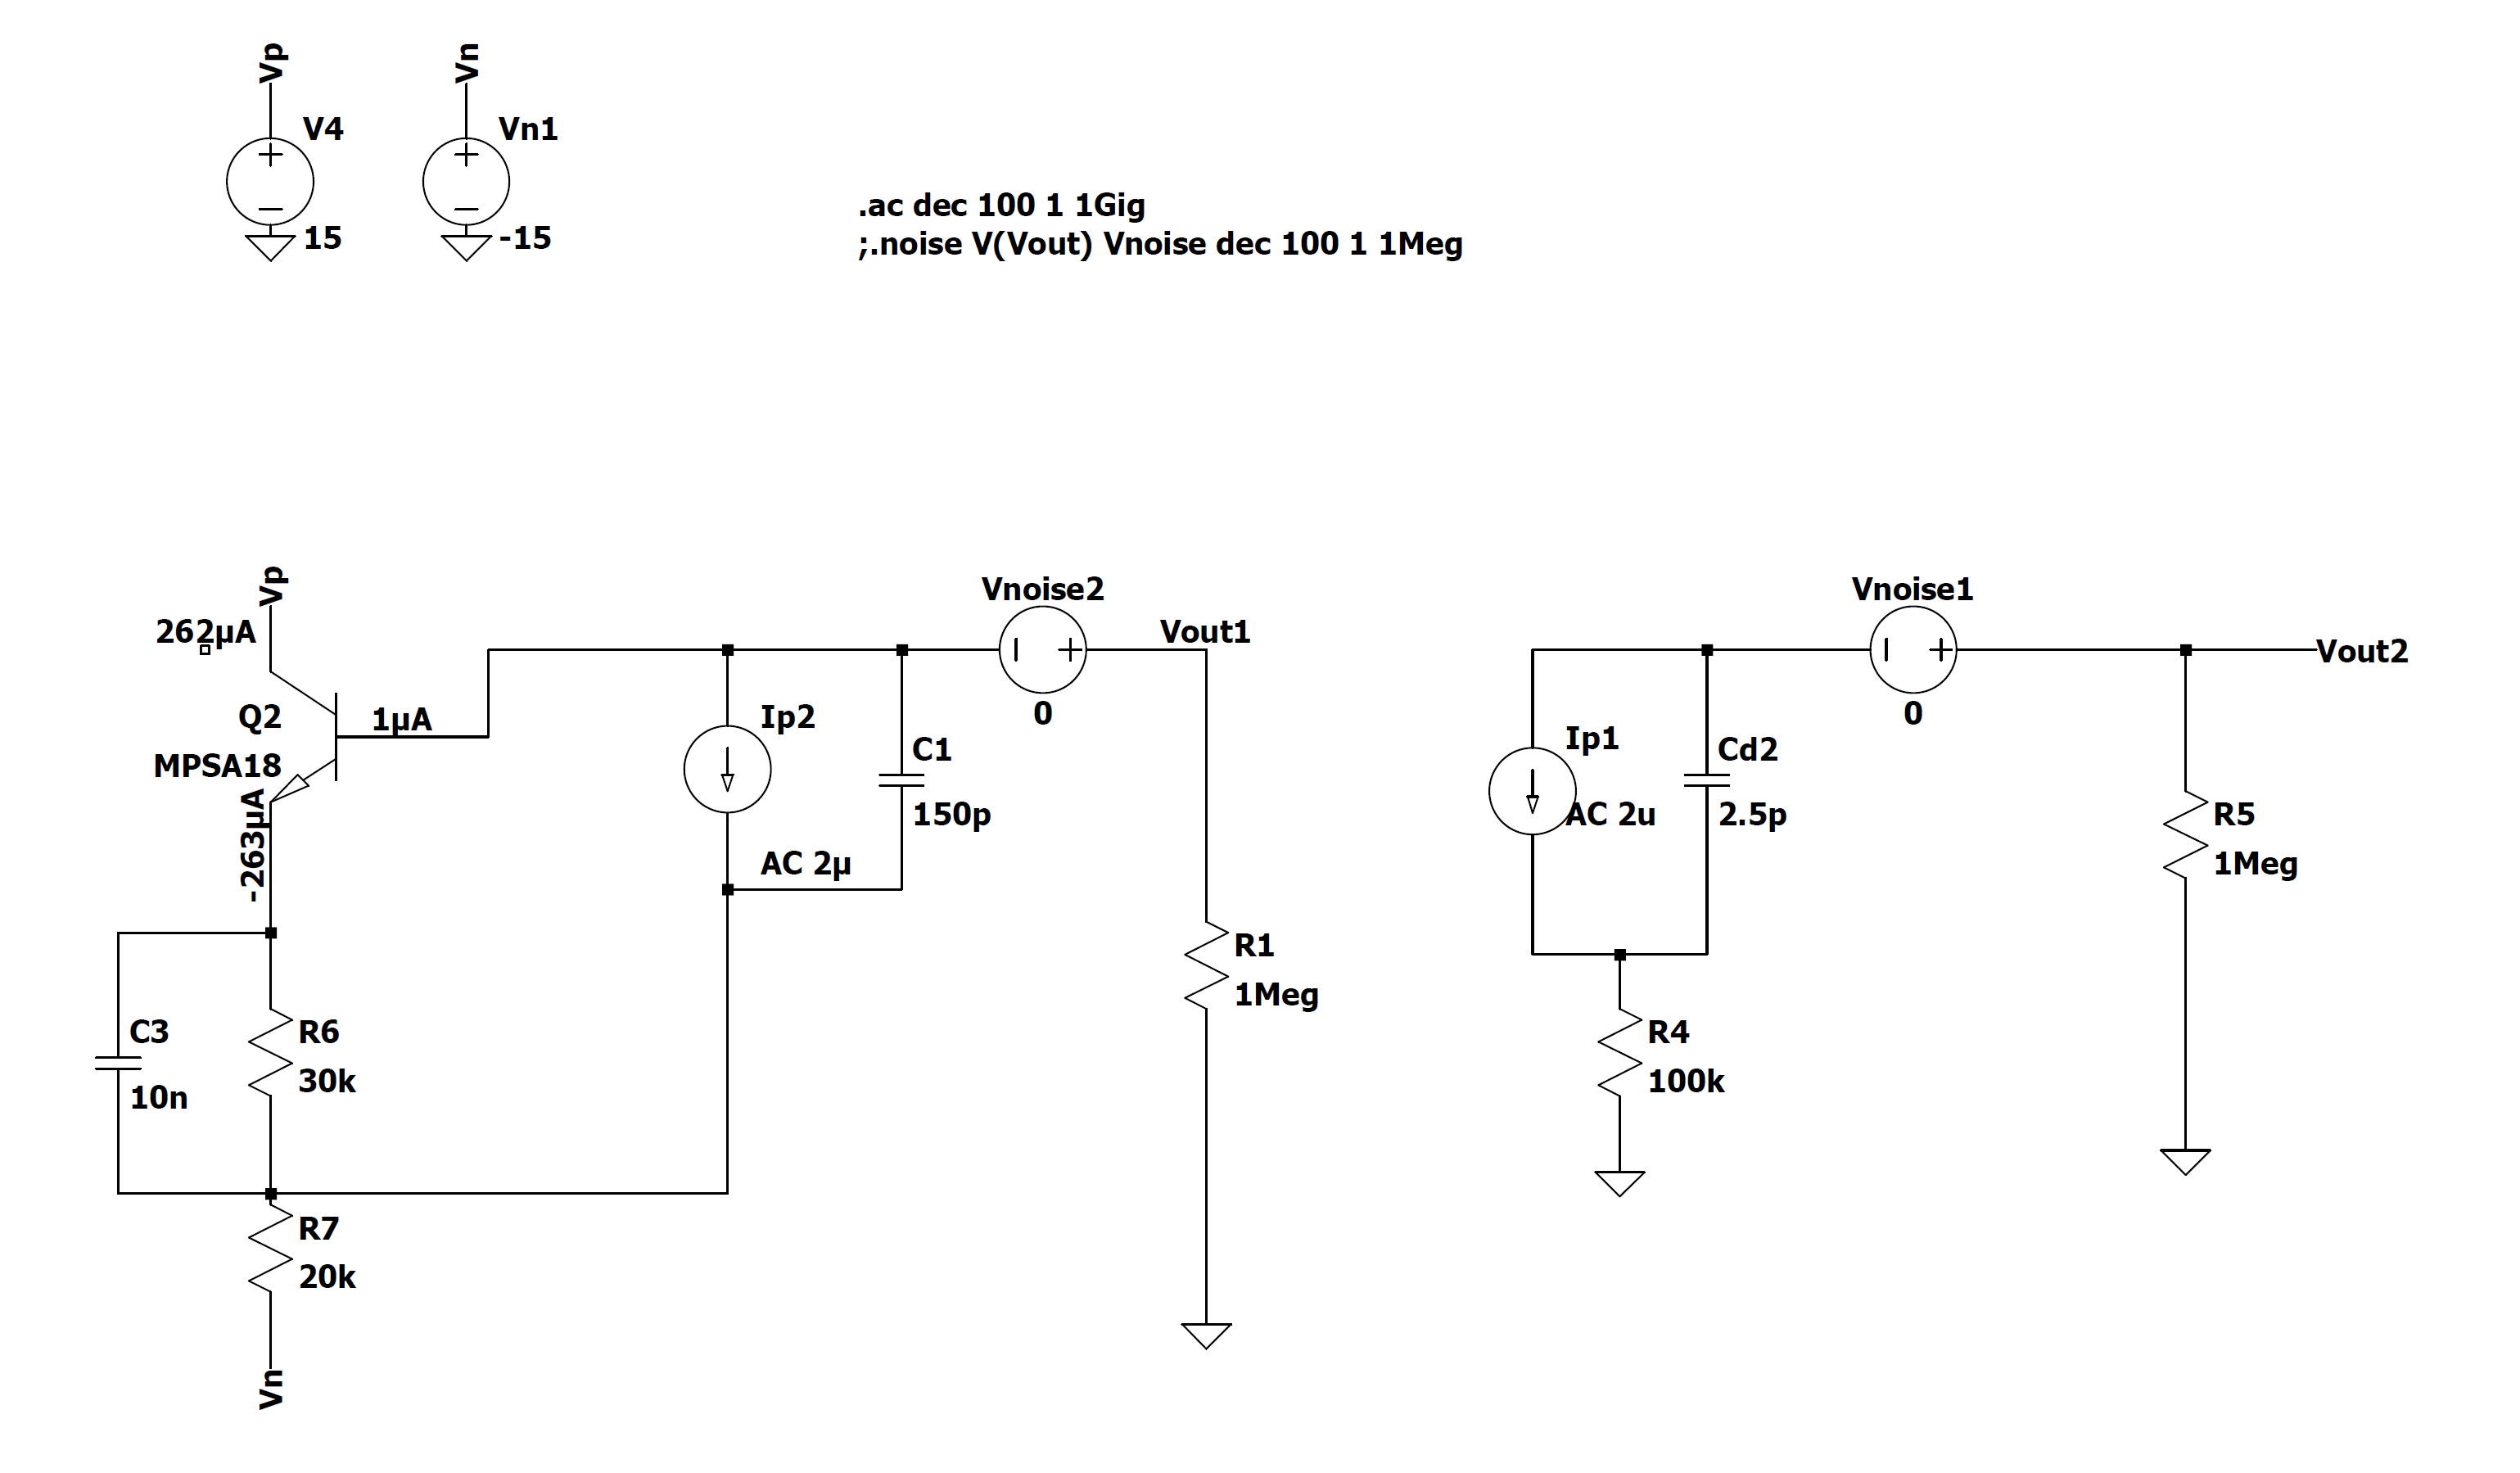

'(x - y)^2/n: 0.17383268740300206'

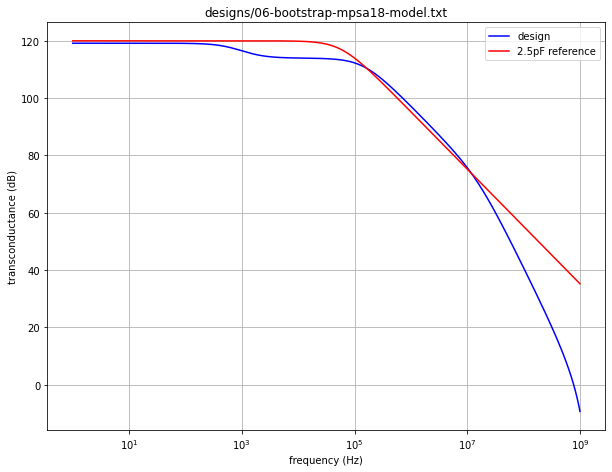

In [52]:
evaluate_frontend("designs/06-bootstrap-mpsa18-model.txt")

'(x - y)^2/n: 0.13332506297040508'

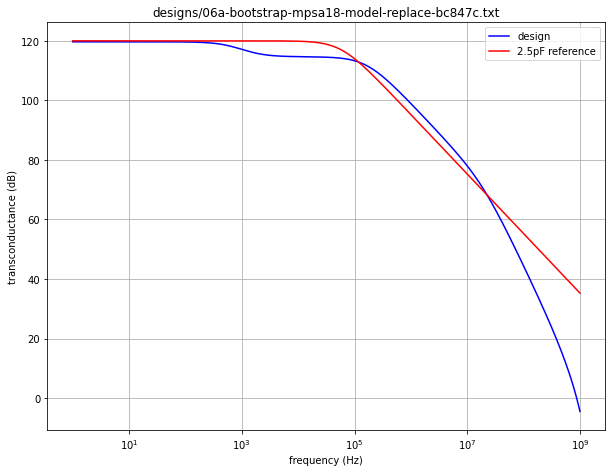

In [55]:
evaluate_frontend("designs/06a-bootstrap-mpsa18-model-replace-bc847c.txt")

In summary, the BC847C transistor performs better than the MPSA18 in both structures:

| structure      | transistor    | delta to 2.5pF |
| :---          | :---       | :----      |
| Hobbs |  MPSA18  | 0.1738 |
| Hobbs |  BC847C  | 0.1333 |
| Diman     |  MPSA18  | 0.1226   |
| Diman     |  BC847C  | 0.0280 |

This is confusing because according to the datasheets both transistors have roughly equivalent parasitic capacitances but the MPSA18 has a far higher hFE. It is possible that the model for the MPSA18 obtained from the ltspice wiki is in accurate but I was unable to find a model from the manufacturer. On the other hand, the branch currents in my simulations seem to match the currents reported in Hobbs' paper.

Regardless of transistor choice, Hobbs structure performs worse. This is because C3 which is shunting R6 is introducing a pole deep inside the signal bandwidth. To alleviate this, C3 and R6 were simply removed in Diman's structure and instead the source follower is AC coupled with the diode through a 100n capacitor. 100n is a value large enough to move the pole it might have introduced outside of the signal bandwidth.

The second point of investigation is the benefit of adding a transistor in a cascode configuration between the diode and IC1. Two answer this question, four configurations were simulated:

1. Hobbs structure with cascode and the UniversalOpamp2 model of an ideal OpAmp
2. Hobbs structure without cascode and with UniversalOpamp2
3. Hobbs structure with cascode and with AD8675
4. Hobbs structure without cascode and with AD8675

The AD8675 was chosen for simulations because no models were available for the LF356 proposed in Hobbs' paper. The AD8675 seems like a reasonable replacement with roughly similar or better device parameters.

The results are summarized as: 

| opamp      | cascode    | no cascode |
| :---       | :---       | :----      |
| UnivOpamp2 |  854.52pV  | 963.26pV   |
| AD8675     |  1.5957nV  | 1.5188nV   |

where the figure shown is input referred noise integrated over a 1MHz bandwidth. The structures based on the AD8675 are shown below. In the alternative configuration, the AD8675 was simply replaced with the UniversalOpamp2 model.

From the simulations it appears that while the proposed cascode structure yields a roughly $10\%$ improvement in input-referred noise when an ideal opamp is assumed, with a real device there may be no improvement and in fact the noise may degrade. This is consistent with the material covered in the lecture. Further, when experimenting with biasing both ends of the cascode transistor, the results from the lecture were fully replicated: the noise peak shifts outside the signal bandwidth but the noise increases due to the Johnson noise of the biasing resistors.

Note, Hobbs is using the BFG25A/X transistor for the cascode. While looking for a model I found that the BFG25A/X is a repackaged version of the BFG25A. Further, I found that the choice of transistor is very important. I was not able to produce a simulation which showed better results with any other transistor when using the ideal opamp. It seems to me that a design which relies so strongly on device characteristics is not future proof but also its performance may vary significantly between individual devices of the same type.

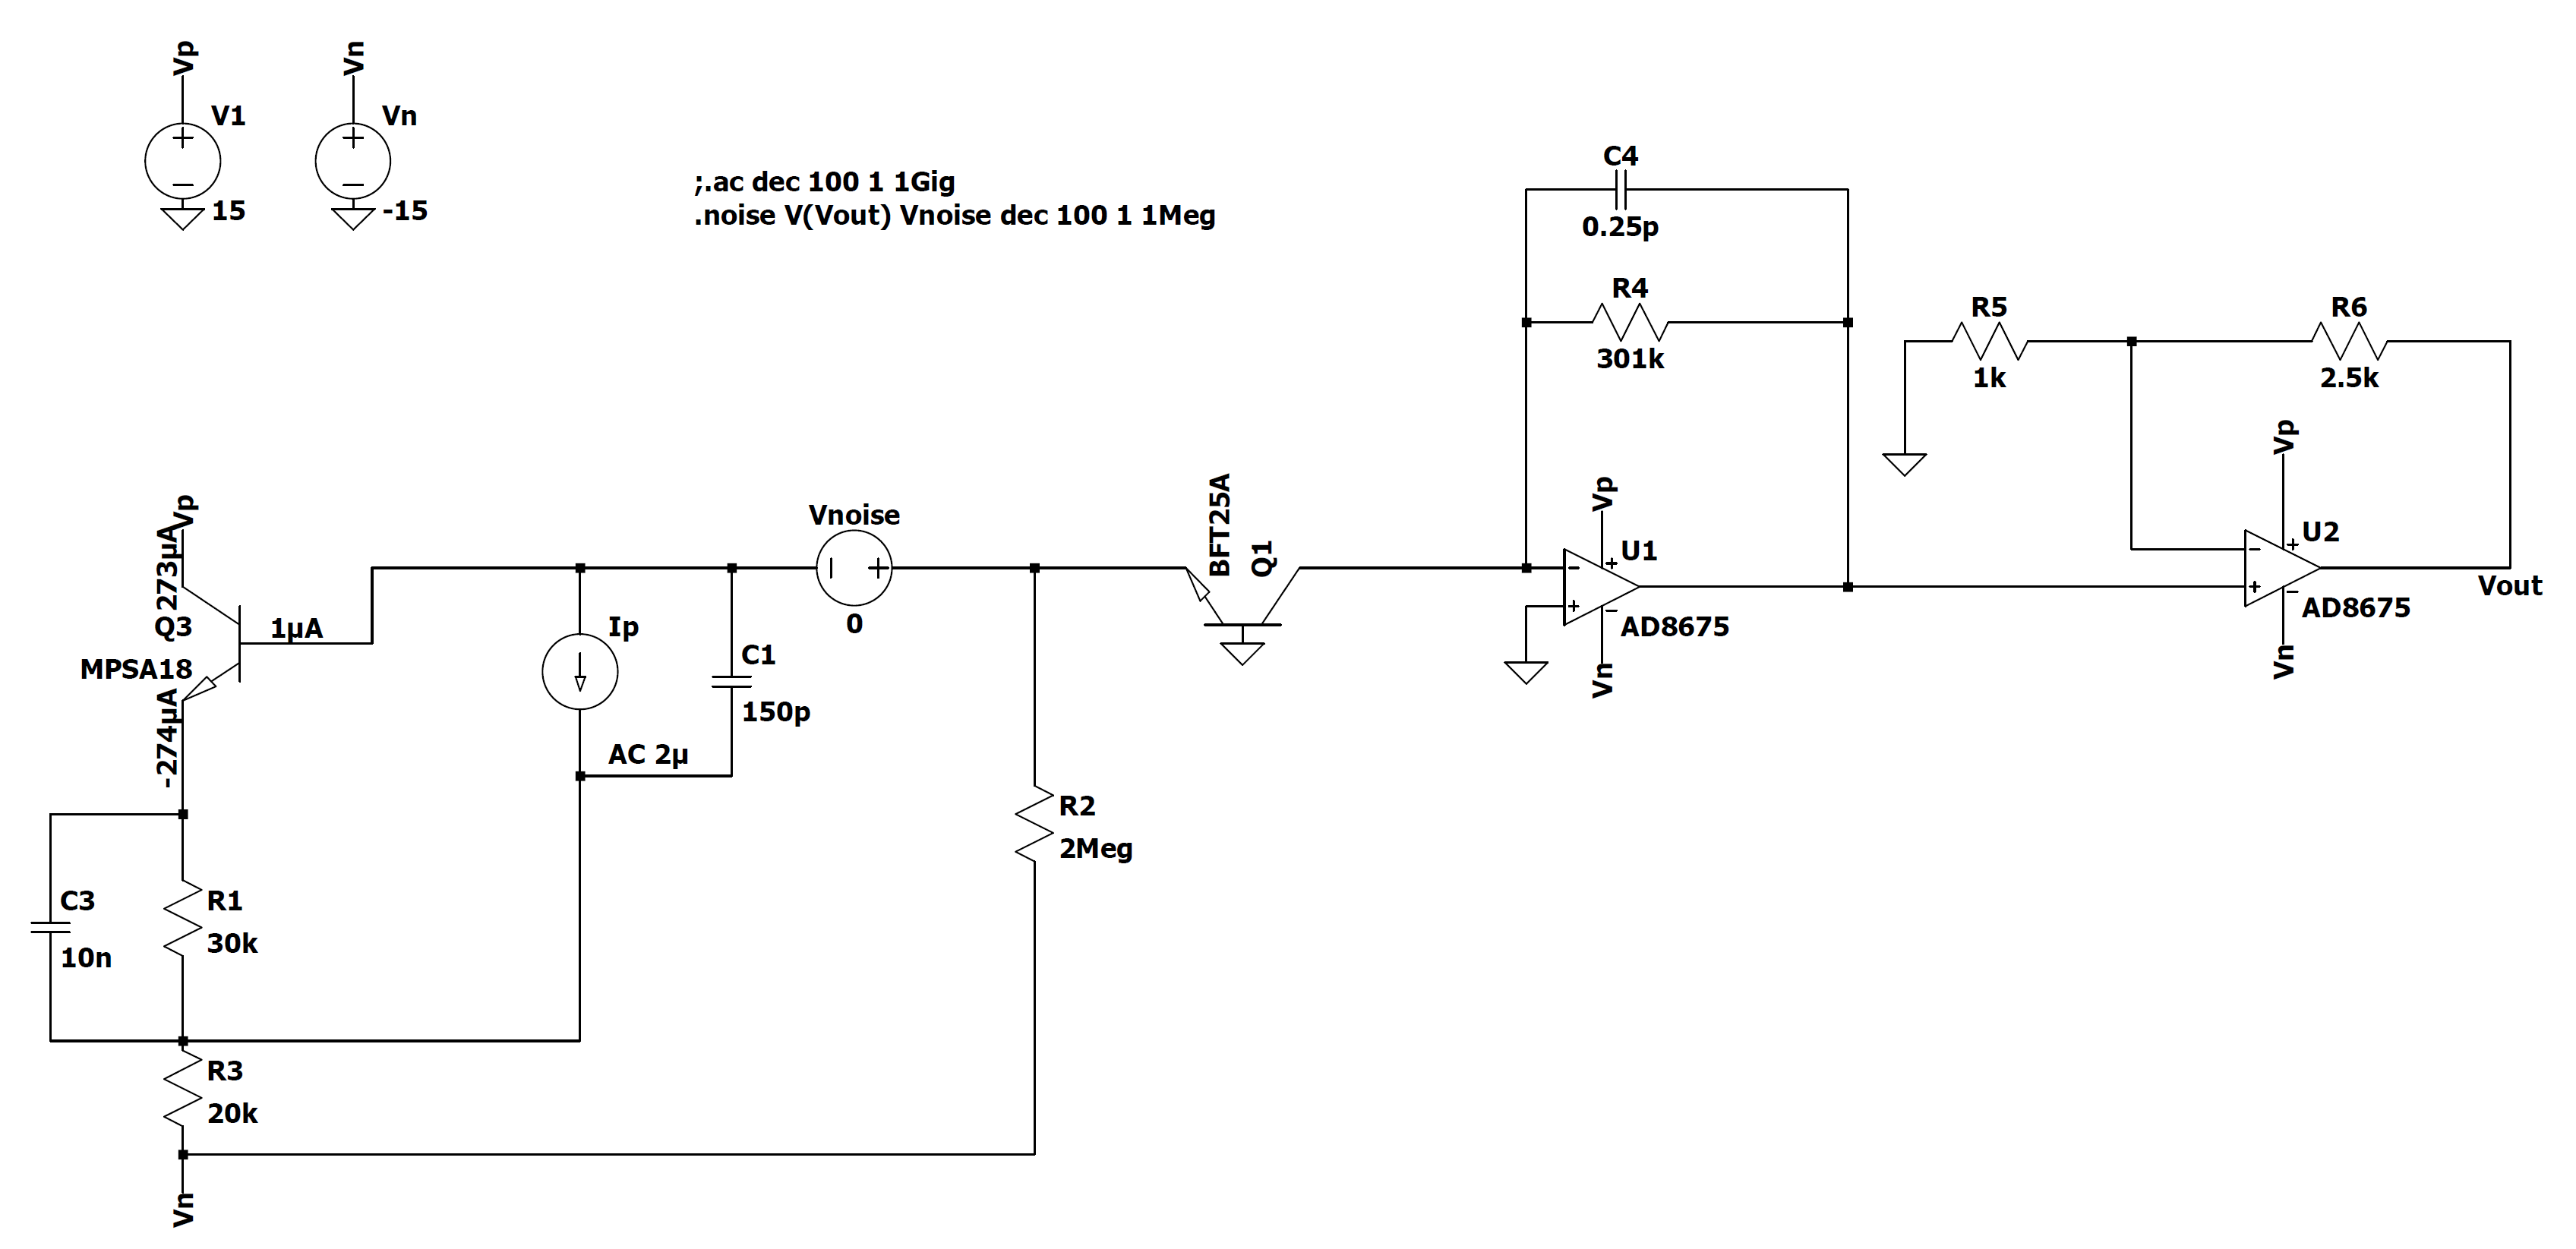


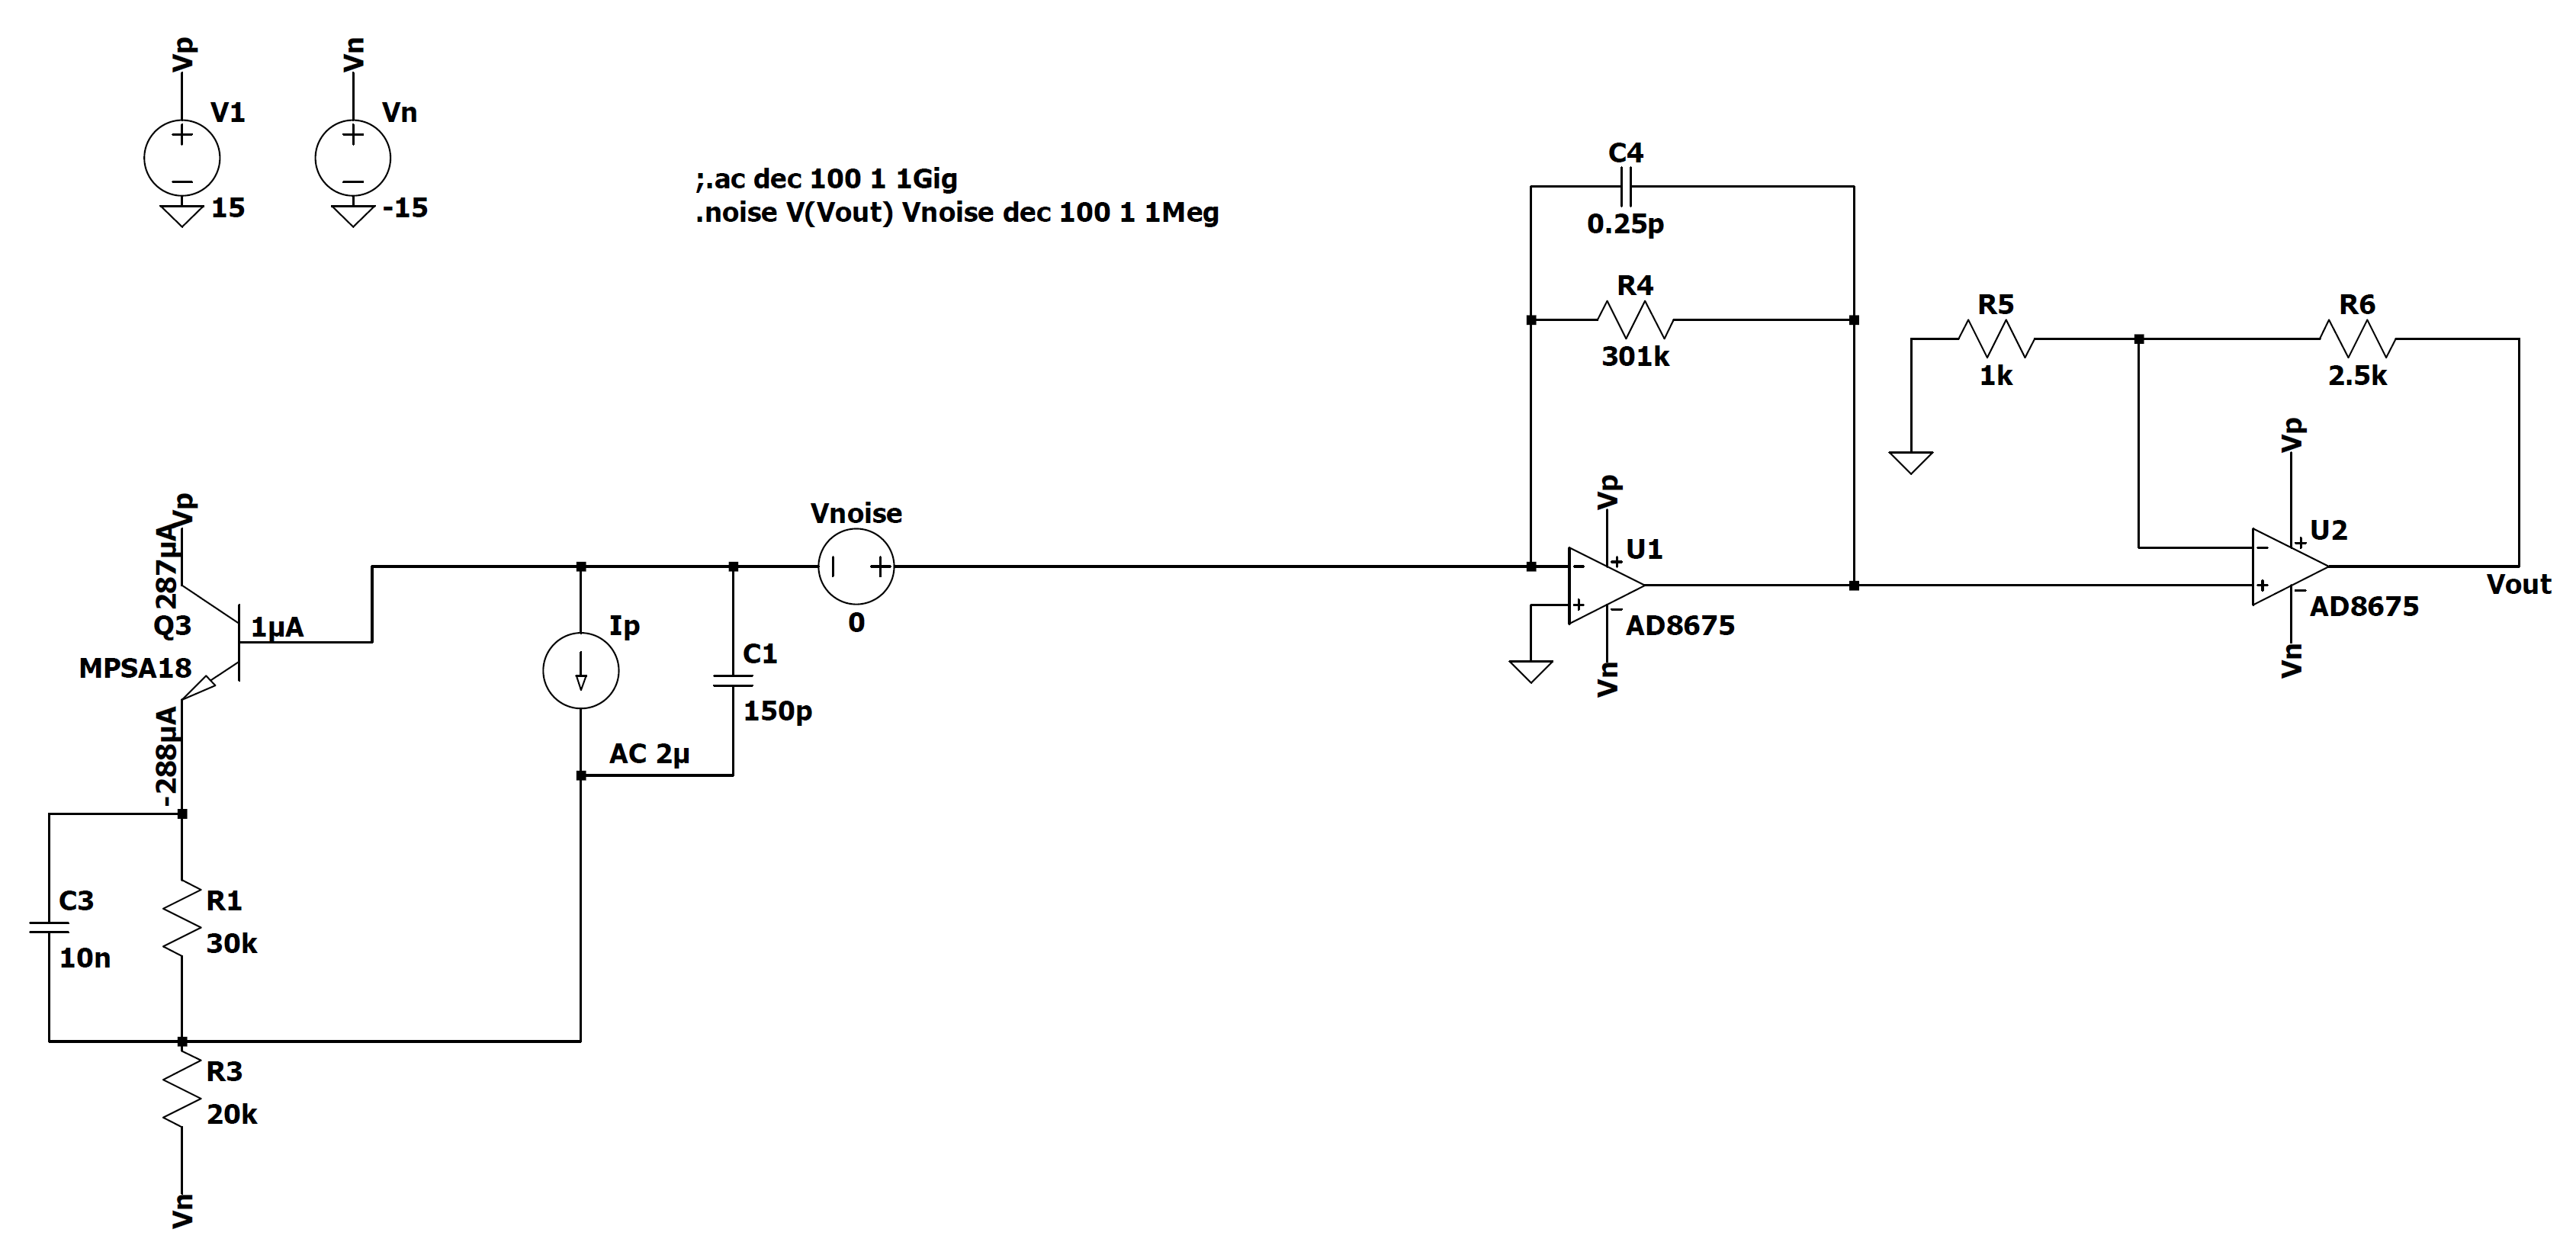